<a href="https://colab.research.google.com/github/adity1234567/Deep-Dive-in-The-Field-of-Misinformation/blob/main/Health_misinformation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://drive.google.com/file/d/1mR0l98g8AZVAjkgjw30JnDNh1l5Jz3ti/view?usp=drive_link


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
!wget https://raw.githubusercontent.com/google-research/bert/master/tokenization.py


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

--2025-04-09 02:30:09--  https://raw.githubusercontent.com/google-research/bert/master/tokenization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12257 (12K) [text/plain]
Saving to: ‘tokenization.py’

tokenization.py     100%[===================>]  11.97K  --.-KB/s    in 0.001s  

2025-04-09 02:30:09 (22.2 MB/s) - ‘tokenization.py’ saved [12257/12257]



In [3]:
import gc
import re
import string
import operator
import sys
import os

from collections import defaultdict

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import word_tokenize, sent_tokenize
import nltk
nltk.download('punkt')

current_dir = os.getcwd()

# Add the current directory to the Python path
sys.path.append(current_dir)

# Now you can import tokenization
from tokenization import FullTokenizer

import tokenization
from wordcloud import STOPWORDS

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

SEED = 1337

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
df=pd.read_csv('/content/drive/MyDrive/Health misinformation/A1_health_misinformation_training_dataset_61220.csv')
df

,ID,Claim,Health Topic,Is Misinformation,Age Group,Culture,Specialization,Gender
0,1447372e-251b-48f7-924d-0ca8c10e20ee,The Ministry of Health recommends regular hand...,Exercise,False,Young Adult,Western,Alternative Healer,Prefer not to say
1,8486426c-d607-465a-aba3-cbee53f1d25c,Health centers are hiding natural cures for ca...,COVID-19,True,Young Adult,Eastern European,Student,Non-binary
2,c35544be-bee6-4917-9cbb-980c6ae91ad8,Traditional bone setting is a complete substit...,Exercise,True,Young Adult,Latin American,General Public,Non-binary
3,9cbe42ee-e2b6-4f25-a31a-7d8704dca7c3,The Ministry of Health recommends regular hand...,Chronic Diseases,False,Senior,East Asian,Student,Non-binary
4,4167f122-1090-40b7-9c65-bb4ff9240255,WHO guidelines advise against using antibiotic...,Weight Loss,False,Adult,Scandinavian,Alternative Healer,Male
...,...,...,...,...,...,...,...,...
61215,b65b6e72-7b85-41b1-bb43-481afe3c717d,Traditional bone setting is a complete substit...,Mental Health,True,Young Adult,South Asian,Health Professional,Prefer not to say
61216,d8654a4c-733b-475a-8d11-fdab81207ca1,The Ministry of Health recommends regular hand...,Exercise,False,Young Adult,South Asian,Student,Prefer not to say
61217,1770bdf0-bf21-4afb-8328-f5b5a34286b5,"In some villages, people believe garlic cures ...",Mental Health,True,Young Adult,Latin American,Alternative Healer,Prefer not to say
61218,0af6a3da-1329-44f6-9512-a80f606a0418,Traditional bone setting is a complete substit...,Antibiotics,True,Adult,South Asian,Health Professional,Prefer not to say


In [5]:
print('Shape = {}'.format(df.shape))
print('Memory Usage = {:.2f} MB'.format(df.memory_usage().sum() / 1024**2))


Shape = (61220, 8)
Memory Usage = 3.33 MB


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61220 entries, 0 to 61219
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 61220 non-null  object
 1   Claim              61220 non-null  object
 2   Health Topic       61220 non-null  object
 3   Is Misinformation  61220 non-null  bool  
 4   Age Group          61220 non-null  object
 5   Culture            61220 non-null  object
 6   Specialization     61220 non-null  object
 7   Gender             61220 non-null  object
dtypes: bool(1), object(7)
memory usage: 3.3+ MB


In [7]:
selected_columns = ['ID', 'Claim', 'Is Misinformation']
df_selected = df[selected_columns]
df_selected.head()

,ID,Claim,Is Misinformation
0,1447372e-251b-48f7-924d-0ca8c10e20ee,The Ministry of Health recommends regular hand...,False
1,8486426c-d607-465a-aba3-cbee53f1d25c,Health centers are hiding natural cures for ca...,True
2,c35544be-bee6-4917-9cbb-980c6ae91ad8,Traditional bone setting is a complete substit...,True
3,9cbe42ee-e2b6-4f25-a31a-7d8704dca7c3,The Ministry of Health recommends regular hand...,False
4,4167f122-1090-40b7-9c65-bb4ff9240255,WHO guidelines advise against using antibiotic...,False


In [8]:
df_selected.describe()

,ID,Claim,Is Misinformation
count,61220,61220,61220
unique,61220,10,2
top,b9e550be-6d74-4efa-8449-aa09ce786958,Local health authorities endorse the COVID-19 ...,False
freq,1,6151,30610


Missing Values

In [9]:
df_selected.isnull().sum()

,0
ID,0
Claim,0
Is Misinformation,0


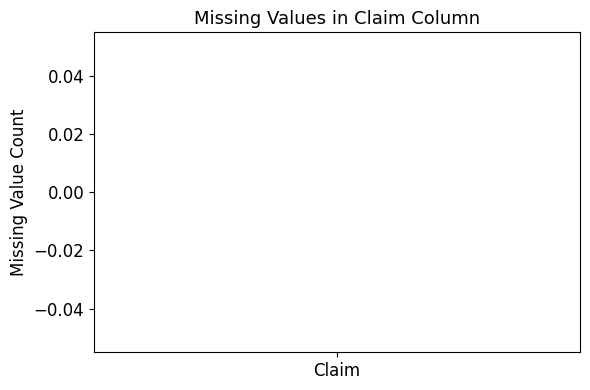

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

col = 'Claim'

# Plot missing value count for df_selected
fig, ax = plt.subplots(figsize=(6, 4), dpi=100)

sns.barplot(x=[col], y=[df_selected[col].isnull().sum()], ax=ax)

ax.set_title('Missing Values in Claim Column', fontsize=13)
ax.set_ylabel('Missing Value Count', fontsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()


In [11]:
print(f'Number of unique values in keyword = {df_selected["Claim"].nunique()} (Training)' )

Number of unique values in keyword = 10 (Training)


In [12]:
df_selected.nunique()

,0
ID,61220
Claim,10
Is Misinformation,2


<ipython-input-13-7bdb4c902389>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['target_mean'] = df_selected.groupby('Claim')['Is Misinformation'].transform('mean')


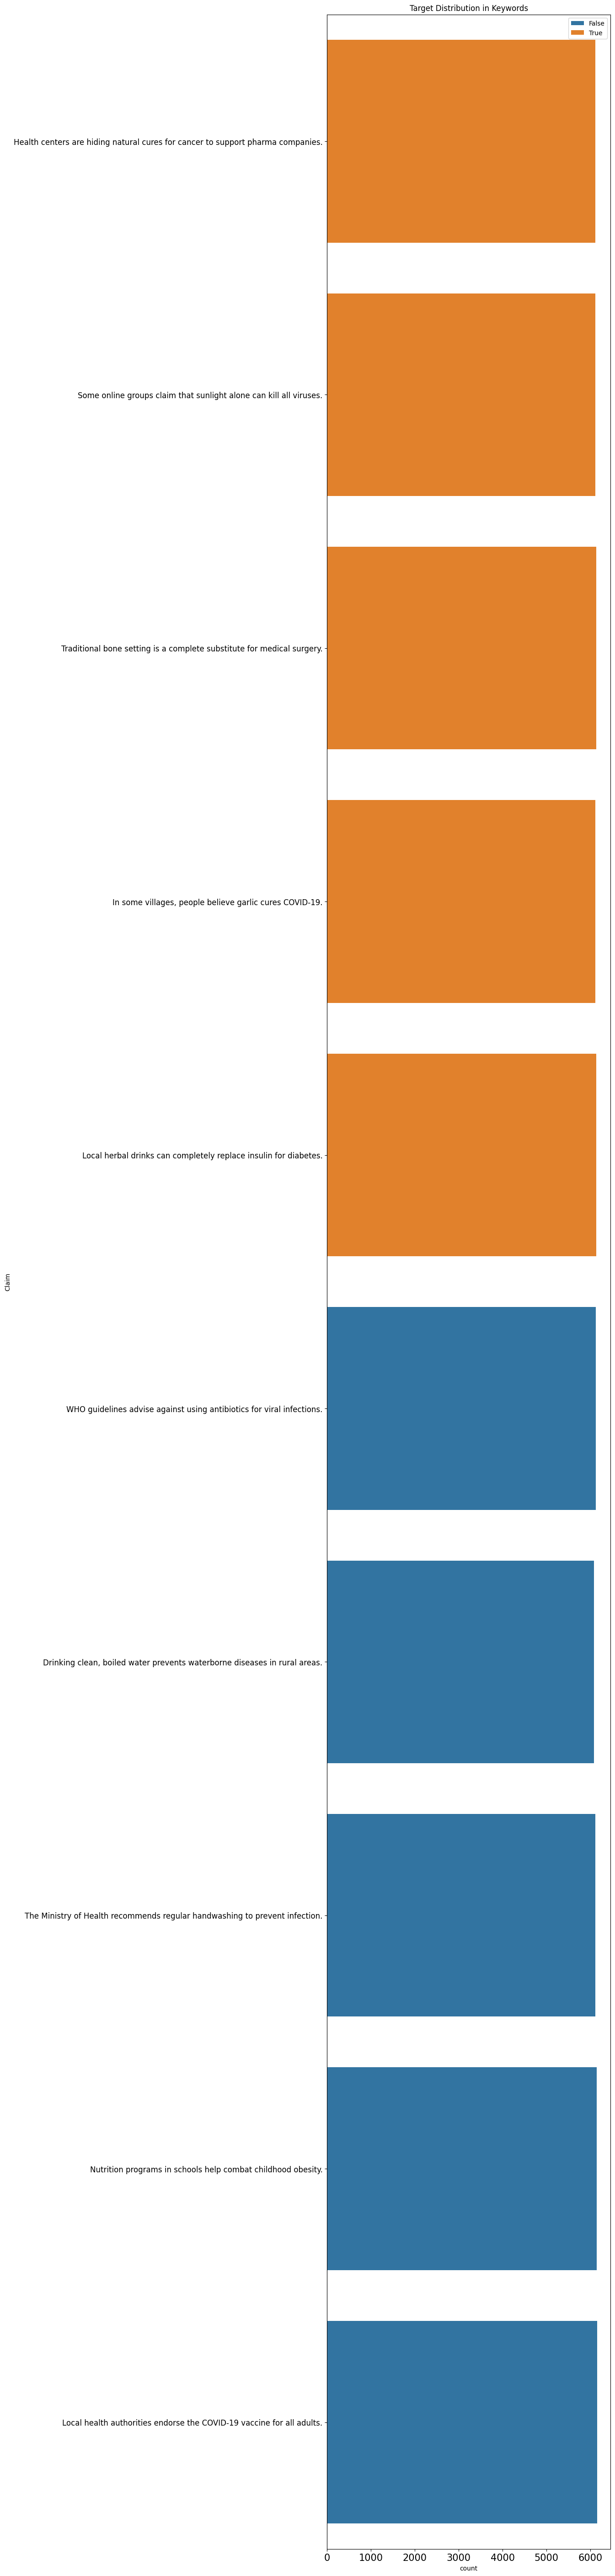

<ipython-input-13-7bdb4c902389>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.drop(columns=['target_mean'], inplace=True)


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

df_selected['target_mean'] = df_selected.groupby('Claim')['Is Misinformation'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=df_selected.sort_values(by='target_mean', ascending=False)['Claim'],
              hue=df_selected.sort_values(by='target_mean', ascending=False)['Is Misinformation'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

df_selected.drop(columns=['target_mean'], inplace=True)

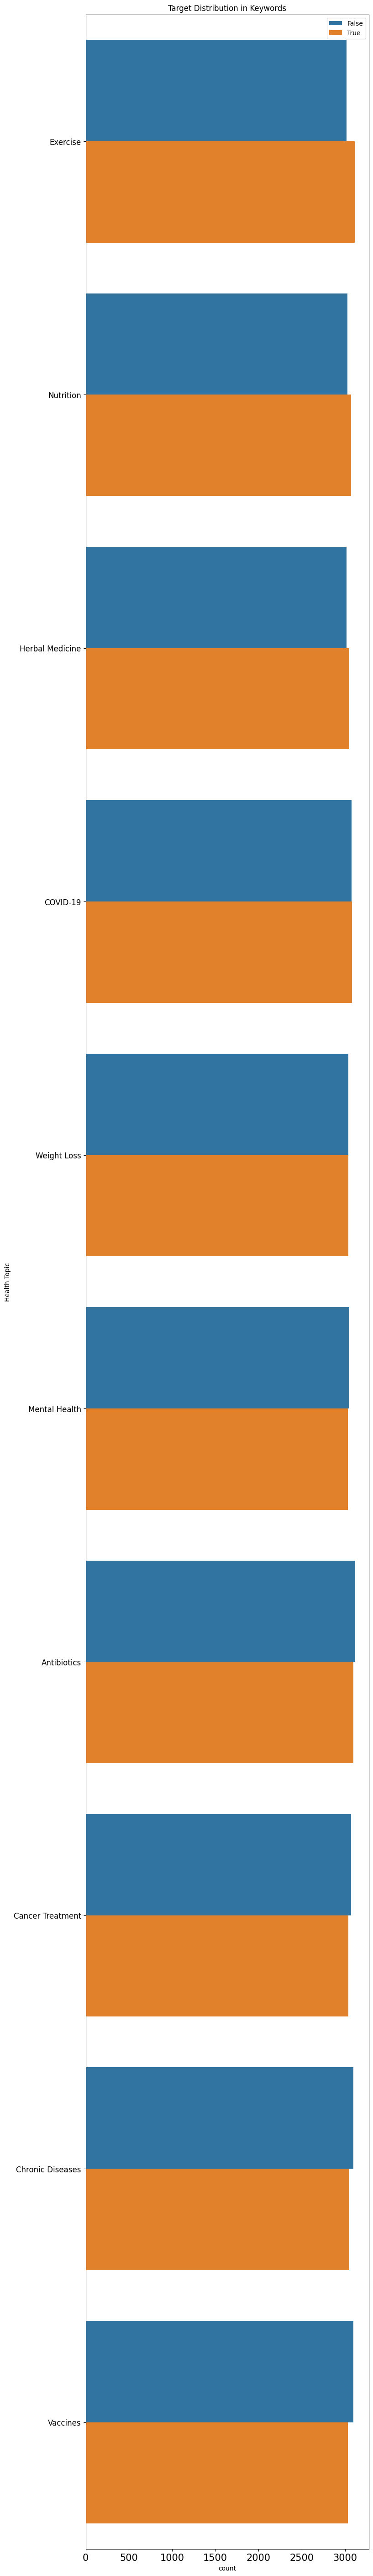

In [14]:
#Health Topic
import matplotlib.pyplot as plt
import seaborn as sns

df['target_mean'] = df.groupby('Health Topic')['Is Misinformation'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=df.sort_values(by='target_mean', ascending=False)['Health Topic'],
              hue=df.sort_values(by='target_mean', ascending=False)['Is Misinformation'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

df.drop(columns=['target_mean'], inplace=True)

In [15]:
# word_count
df_selected['word_count'] = df_selected['Claim'].apply(lambda x: len(str(x).split()))

# unique_word_count
df_selected['unique_word_count'] = df_selected['Claim'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df_selected['stop_word_count'] = df_selected['Claim'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
df_selected['url_count'] = df_selected['Claim'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
df_selected['mean_word_length'] = df_selected['Claim'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df_selected['char_count'] = df_selected['Claim'].apply(lambda x: len(str(x)))

# punctuation_count
df_selected['punctuation_count'] = df_selected['Claim'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
df_selected['hashtag_count'] = df_selected['Claim'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
df_selected['mention_count'] = df_selected['Claim'].apply(lambda x: len([c for c in str(x) if c == '@']))


<ipython-input-15-e3e9c1df62d9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['word_count'] = df_selected['Claim'].apply(lambda x: len(str(x).split()))
<ipython-input-15-e3e9c1df62d9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['unique_word_count'] = df_selected['Claim'].apply(lambda x: len(set(str(x).split())))
<ipython-input-15-e3e9c1df62d9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [16]:
df_selected['unique_word_count']

,unique_word_count
0,10
1,12
2,10
3,10
4,9
...,...
61215,10
61216,10
61217,8
61218,10


In [17]:
import numpy as np
import string
from wordcloud import STOPWORDS

def extract_text_features(df_selected):
    df_selected['word_count'] = df_selected['Claim'].apply(lambda x: len(str(x).split()))
    df_selected['unique_word_count'] = df_selected['Claim'].apply(lambda x: len(set(str(x).split())))
    df_selected['stop_word_count'] = df_selected['Claim'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
    df_selected['url_count'] = df_selected['Claim'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
    df_selected['mean_word_length'] = df_selected['Claim'].apply(lambda x: np.mean([len(w) for w in str(x).split()]) if len(str(x).split()) > 0 else 0)
    df_selected['char_count'] = df_selected['Claim'].apply(lambda x: len(str(x)))
    df_selected['punctuation_count'] = df_selected['Claim'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    df_selected['hashtag_count'] = df_selected['Claim'].apply(lambda x: str(x).count('#'))
    df_selected['mention_count'] = df_selected['Claim'].apply(lambda x: str(x).count('@'))
    return df_selected




<ipython-input-18-9a45f9bfd37c>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df_selected.loc[~DISASTER_TWEETS][feature], label='False', ax=axes[i][0], color='green')
<ipython-input-18-9a45f9bfd37c>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df_selected.loc[DISASTER_TWEETS][feature], 

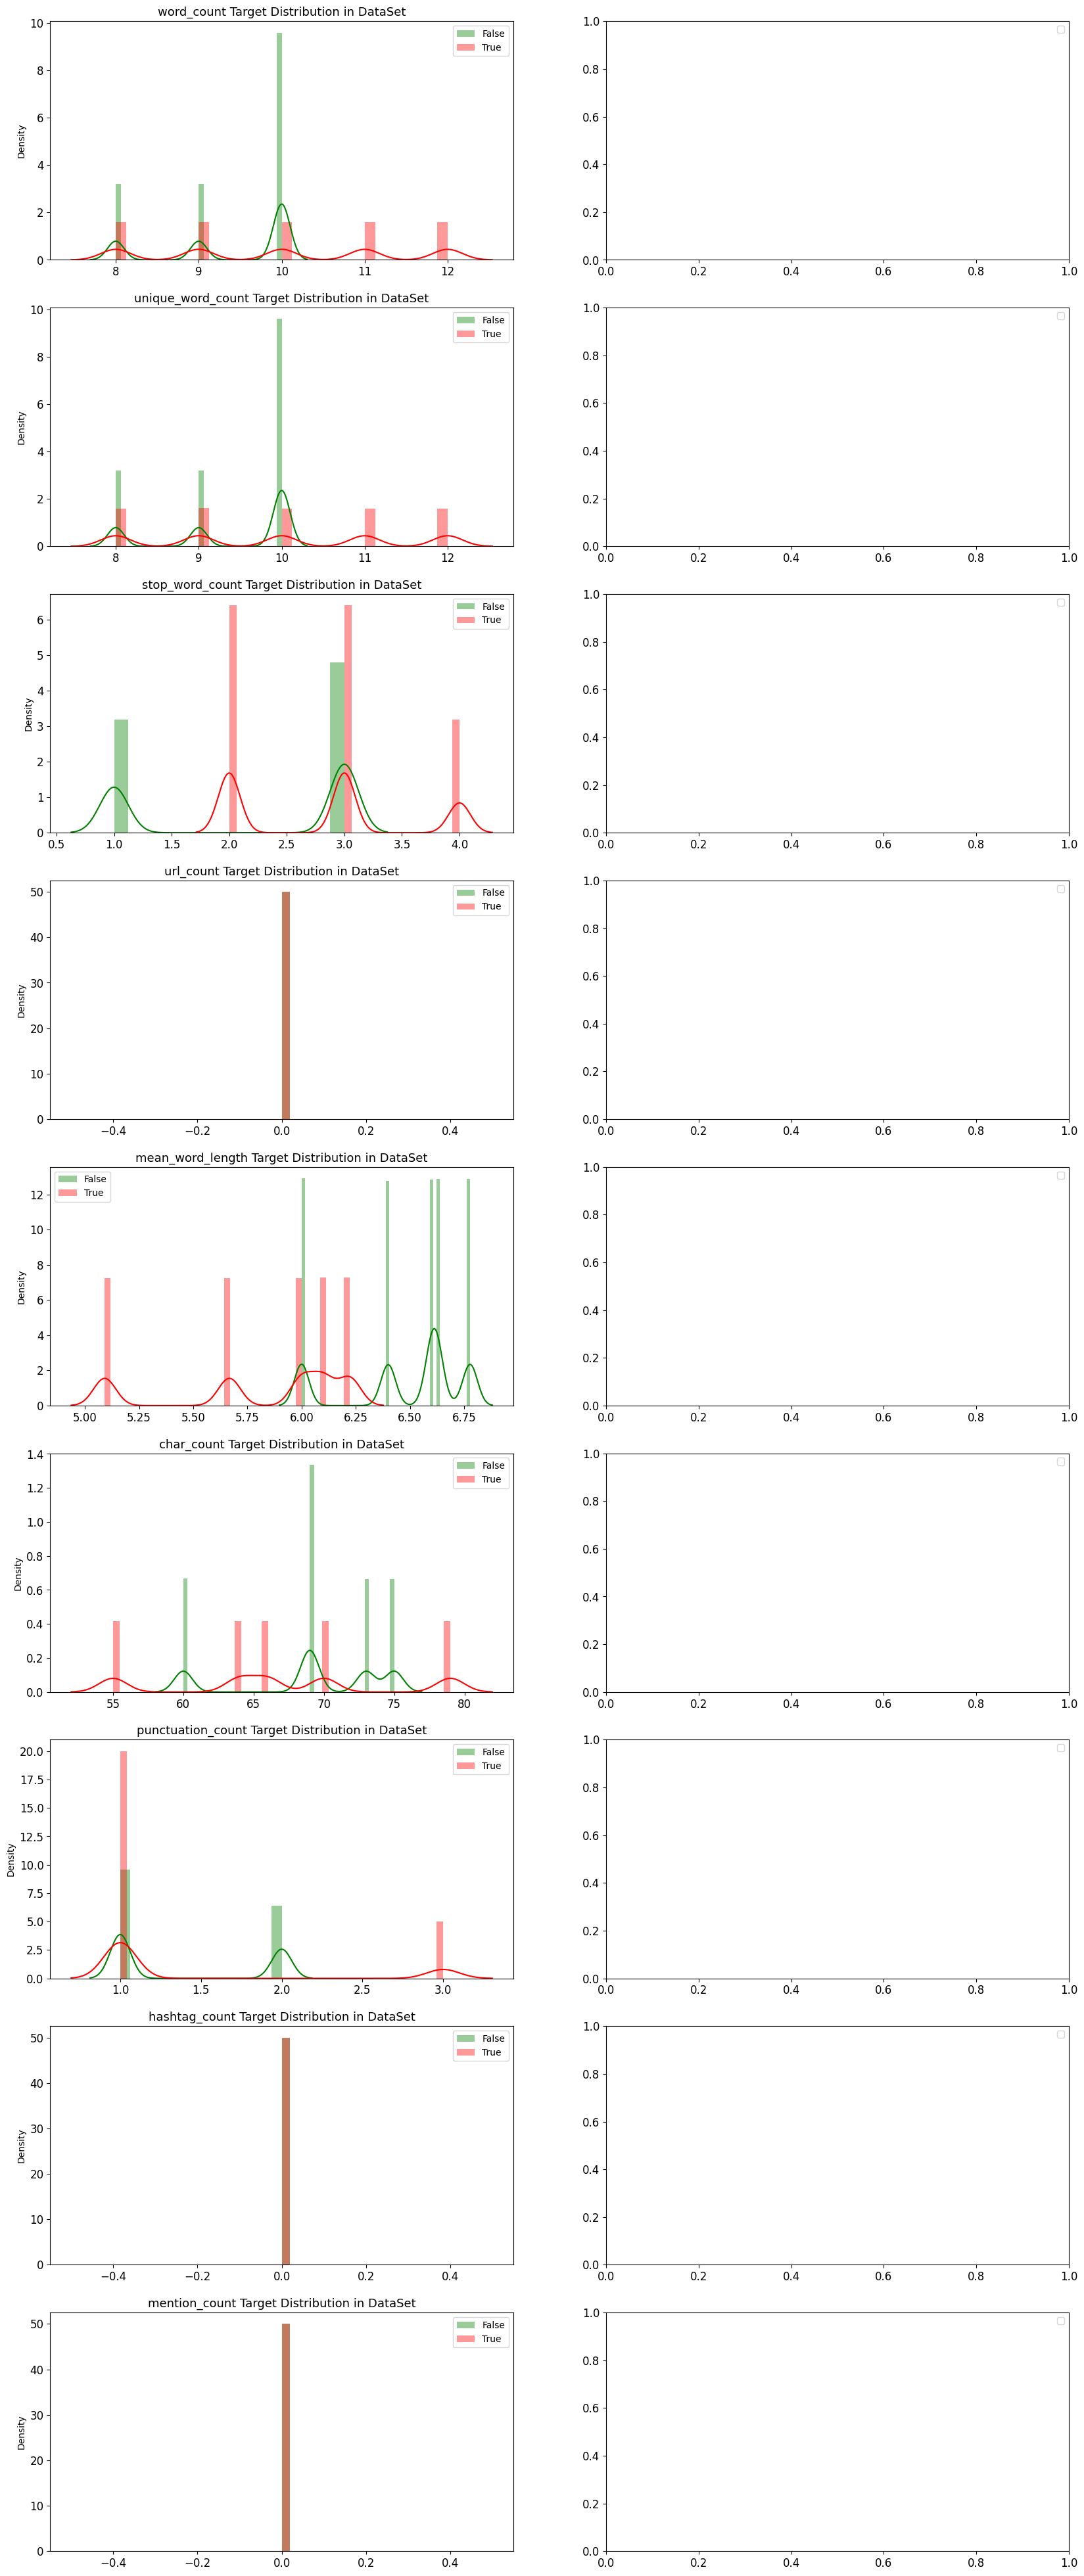

In [18]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']
DISASTER_TWEETS = df_selected['Is Misinformation'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot( df_selected.loc[~DISASTER_TWEETS][feature], label='False', ax=axes[i][0], color='green')
    sns.distplot( df_selected.loc[DISASTER_TWEETS][feature], label='True', ax=axes[i][0], color='red')

    #sns.distplot(df_selected[feature], label='DATA', ax=axes[i][1])


    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()

    axes[i][0].set_title(f'{feature} Target Distribution in DataSet', fontsize=13)


plt.show()


In [19]:
from sklearn.model_selection import train_test_split

# Split the data: 80% training, 20% testing
df_train, df_test = train_test_split(df_selected, test_size=0.2, random_state=42, stratify=df['Is Misinformation'])

print("Training shape:", df_train.shape)
print("Testing shape:", df_test.shape)


Training shape: (48976, 12)
Testing shape: (12244, 12)


In [20]:
df_train.head(1)

,ID,Claim,Is Misinformation,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count
7726,3dcc167d-b39d-4bd0-b536-81f0a9124927,Traditional bone setting is a complete substit...,True,10,10,3,0,6.1,70,1,0,0


In [21]:
df_train = extract_text_features(df_train)
df_test = extract_text_features(df_test)

<ipython-input-22-a83542101963>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train.loc[~misinformation][feature], label='False', ax=axes[i][0], color='green')
<ipython-input-22-a83542101963>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train.loc[misinformation][feature], label='Tru

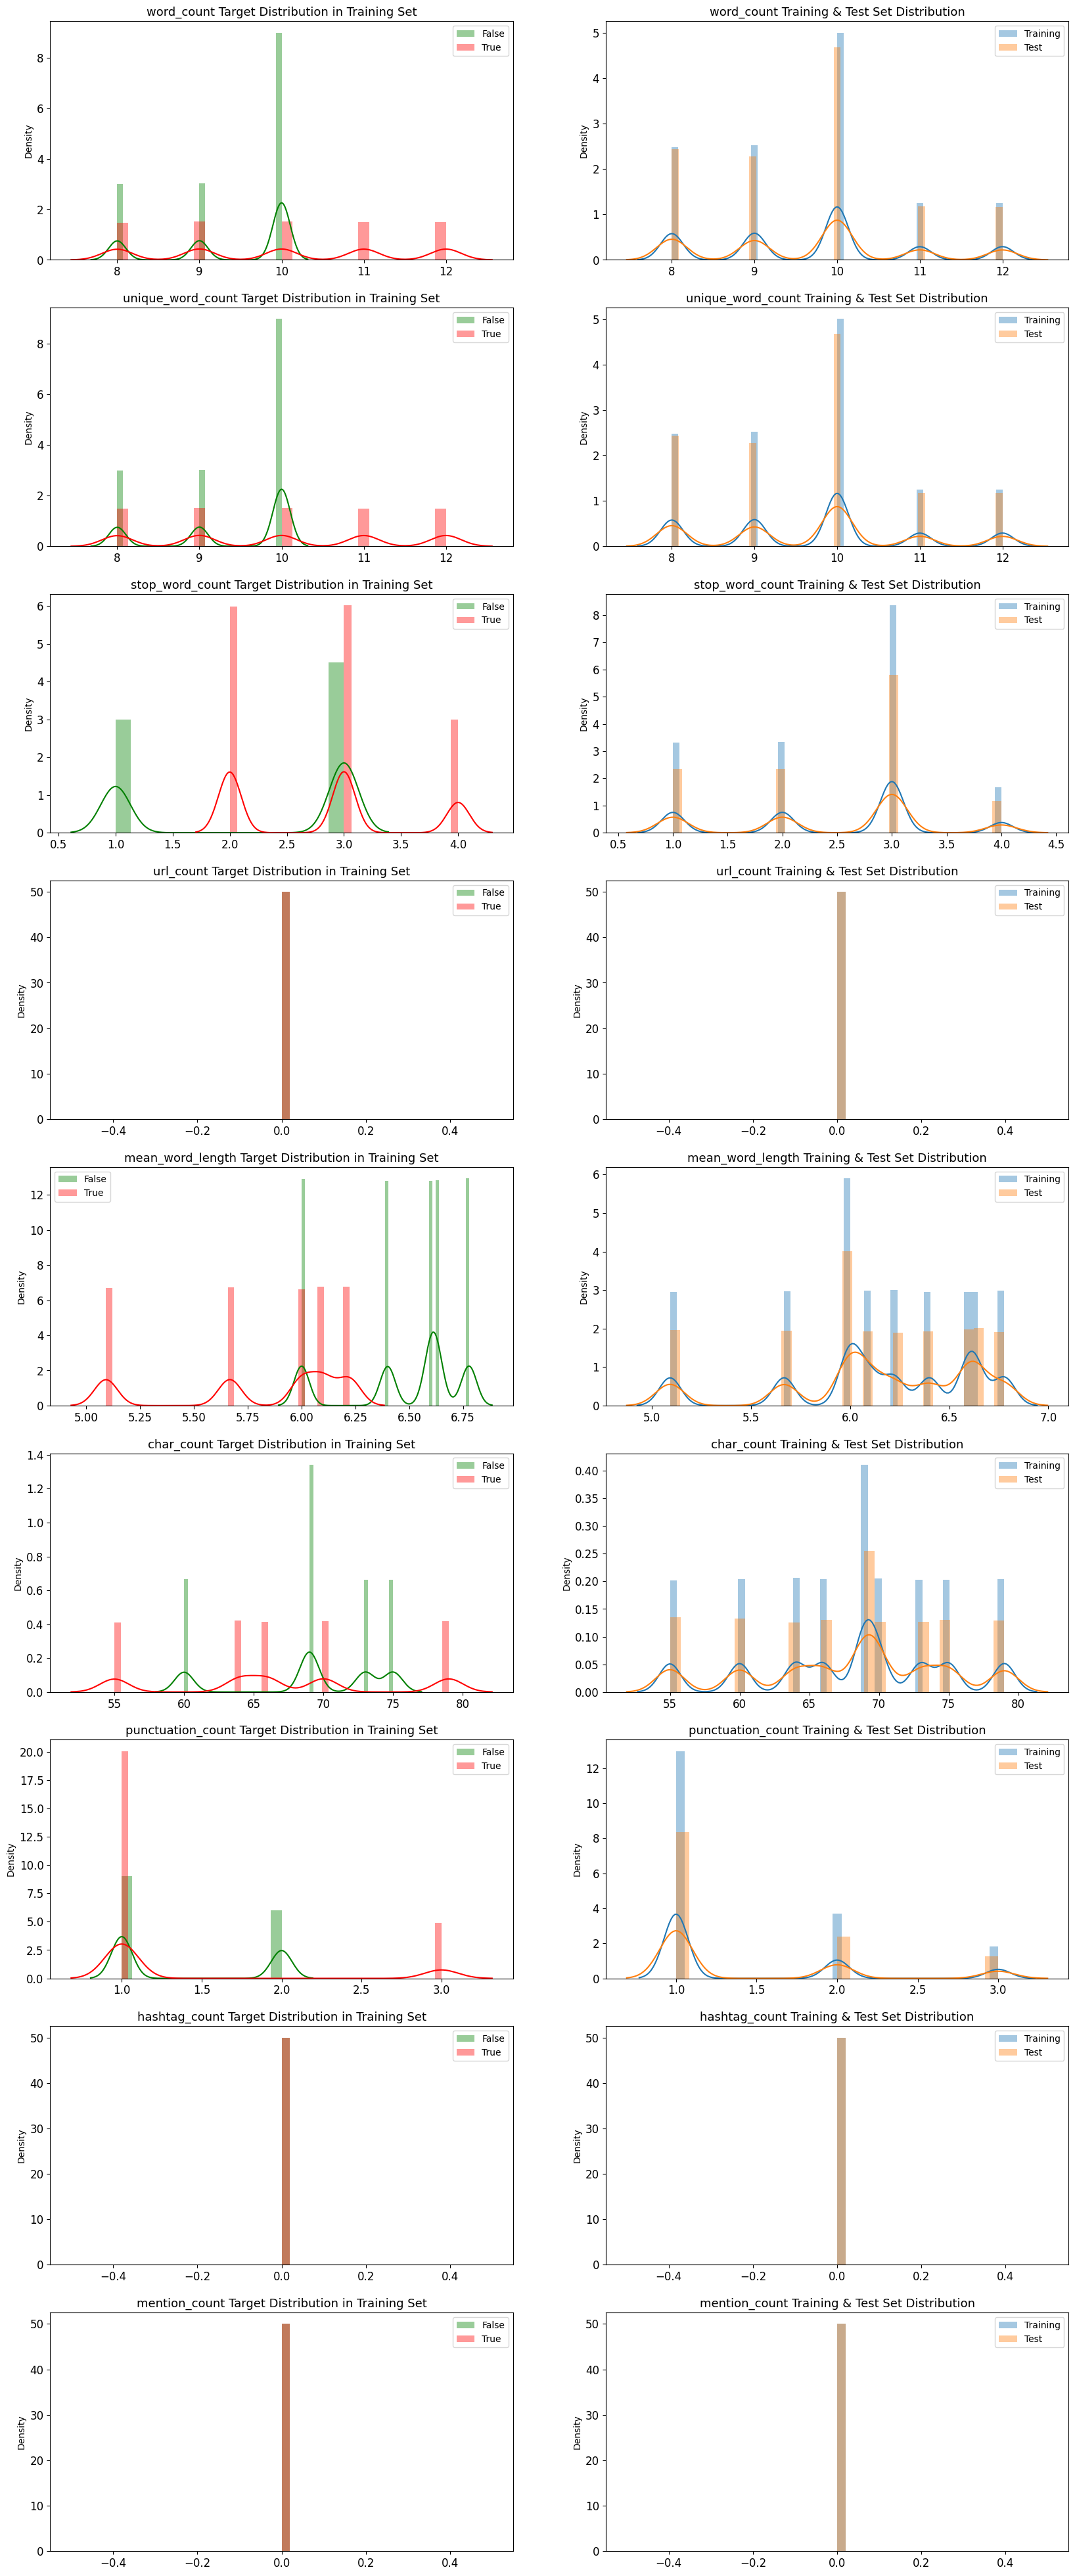

In [22]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']
misinformation = df_train['Is Misinformation'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(df_train.loc[~misinformation][feature], label='False', ax=axes[i][0], color='green')
    sns.distplot(df_train.loc[misinformation][feature], label='True', ax=axes[i][0], color='red')

    sns.distplot(df_train[feature], label='Training', ax=axes[i][1])
    sns.distplot(df_test[feature], label='Test', ax=axes[i][1])

    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()

    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

<ipython-input-23-ad1940f0183c>:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['False','True'])


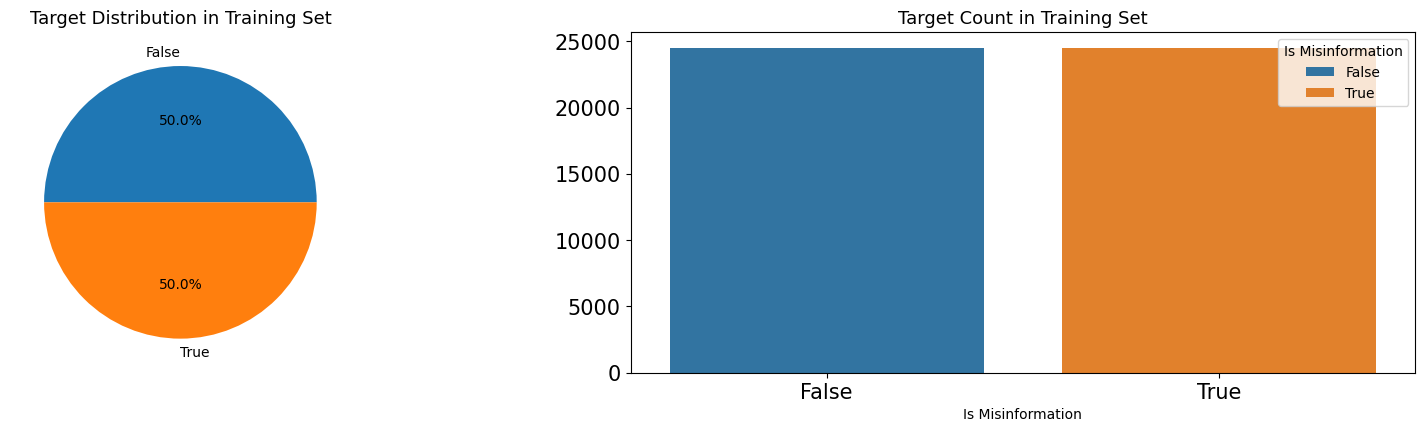

Is Misinformation
True     24488
False    24488
Name: count, dtype: int64


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

# Plot pie chart with percentages
df_train.groupby('Is Misinformation').count()['ID'].plot(kind='pie', ax=axes[0], labels=['False', 'True'], autopct='%1.1f%%')

# Plot countplot
sns.countplot(x=df_train['Is Misinformation'], hue=df_train['Is Misinformation'], ax=axes[1])

# Set labels and titles
axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['False','True'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

# Set titles
axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

value_counts = df_train['Is Misinformation'].value_counts()

print(value_counts)


In [24]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 100

# Unigrams
disaster_unigrams = defaultdict(int)
nondisaster_unigrams = defaultdict(int)

for tweet in df_train[misinformation]['Claim']:
    for word in generate_ngrams(tweet):
        disaster_unigrams[word] += 1

for tweet in df_train[~misinformation]['Claim']:
    for word in generate_ngrams(tweet):
        nondisaster_unigrams[word] += 1

df_disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])

# Bigrams
disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

for tweet in df_train[misinformation]['Claim']:
    for word in generate_ngrams(tweet, n_gram=2):
        disaster_bigrams[word] += 1

for tweet in df_train[~misinformation]['Claim']:
    for word in generate_ngrams(tweet, n_gram=2):
        nondisaster_bigrams[word] += 1

df_disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])

# Trigrams
disaster_trigrams = defaultdict(int)
nondisaster_trigrams = defaultdict(int)

for tweet in df_train[misinformation]['Claim']:
    for word in generate_ngrams(tweet, n_gram=3):
        disaster_trigrams[word] += 1

for tweet in df_train[~misinformation]['Claim']:
    for word in generate_ngrams(tweet, n_gram=3):
        nondisaster_trigrams[word] += 1

df_disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1])

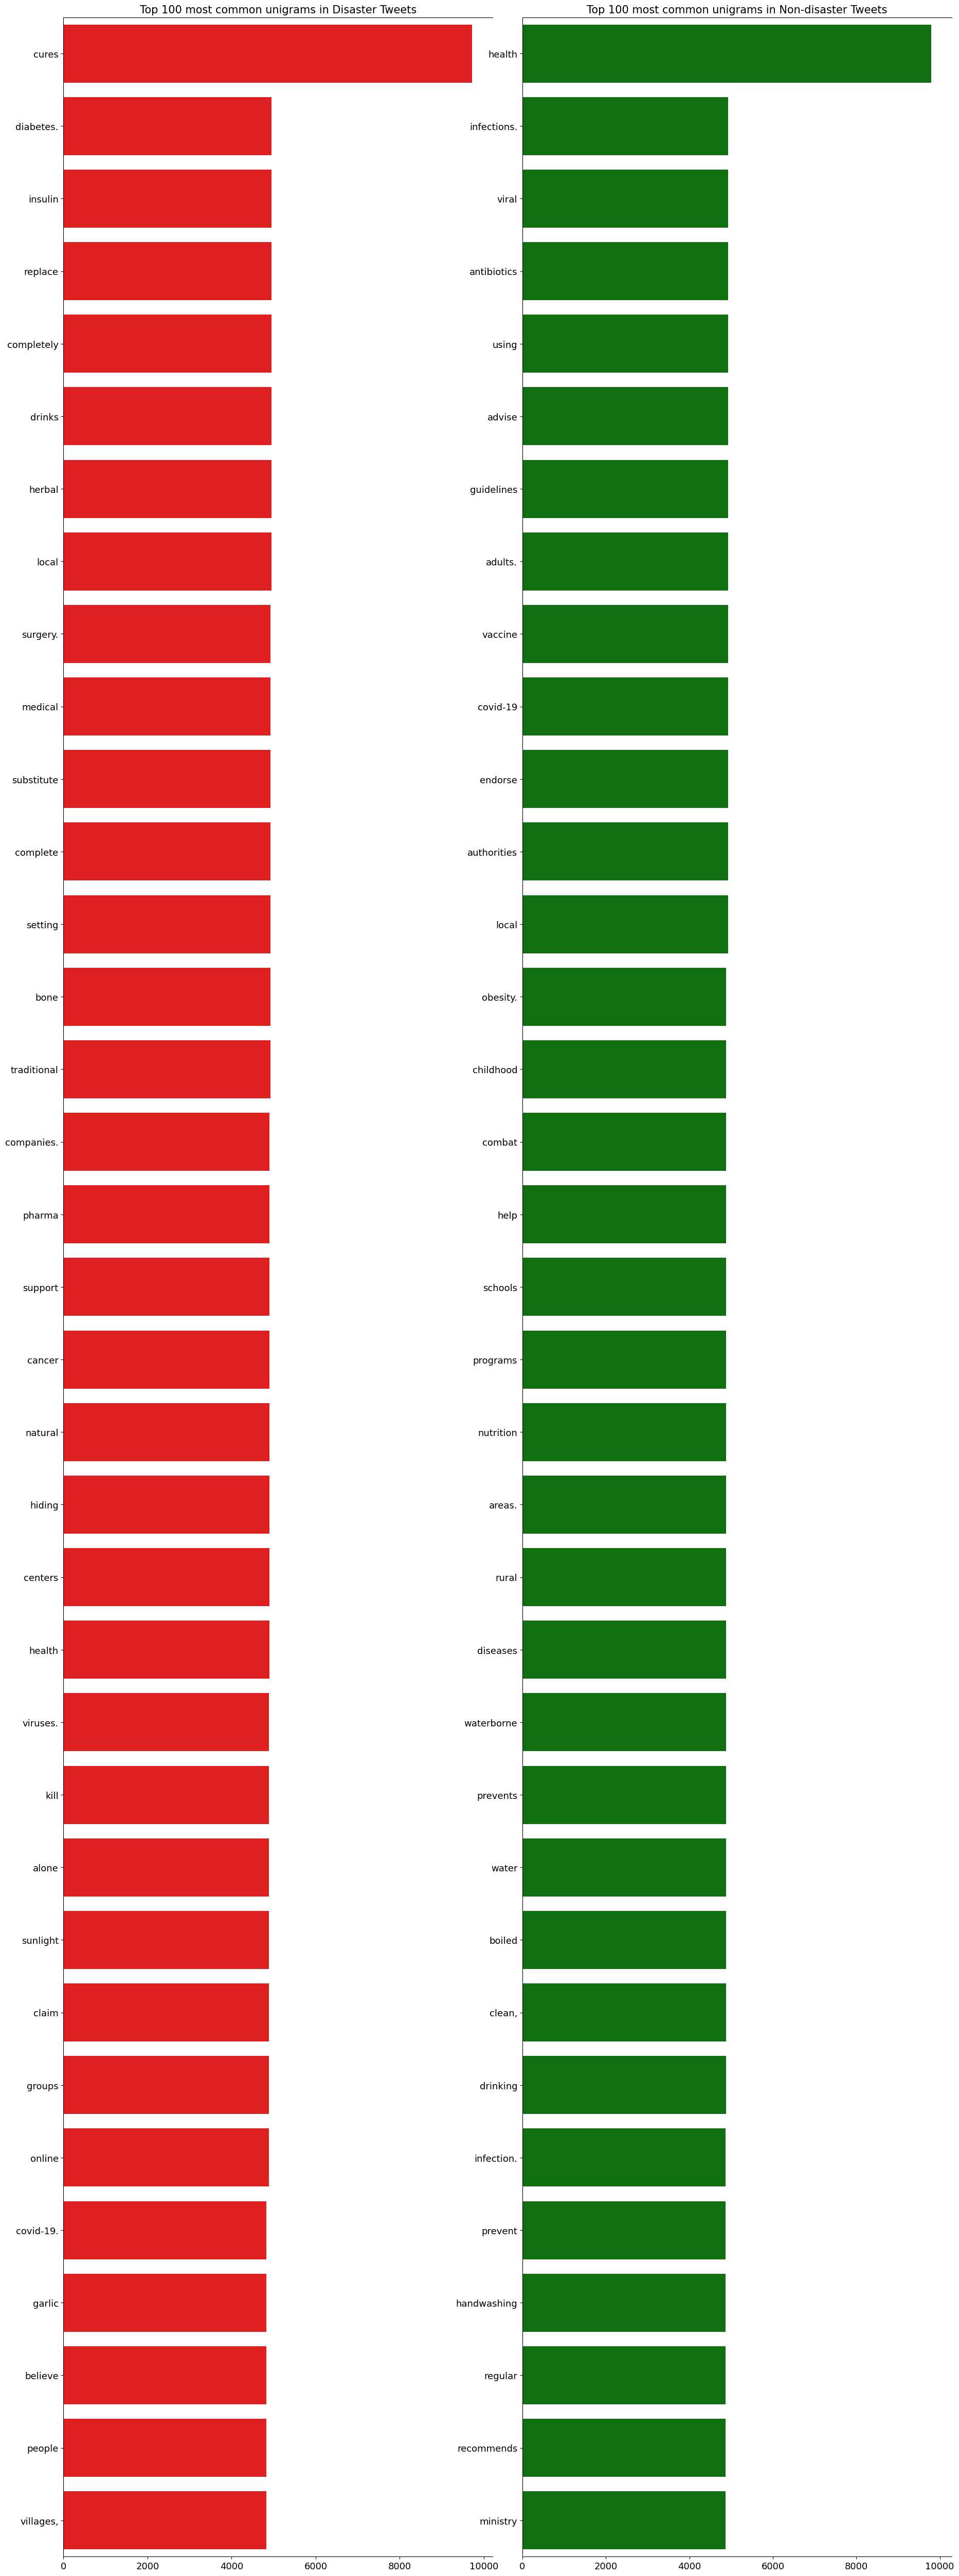

In [25]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_unigrams[0].values[:N], x=df_disaster_unigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_unigrams[0].values[:N], x=df_nondisaster_unigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common unigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Non-disaster Tweets', fontsize=15)

plt.show()


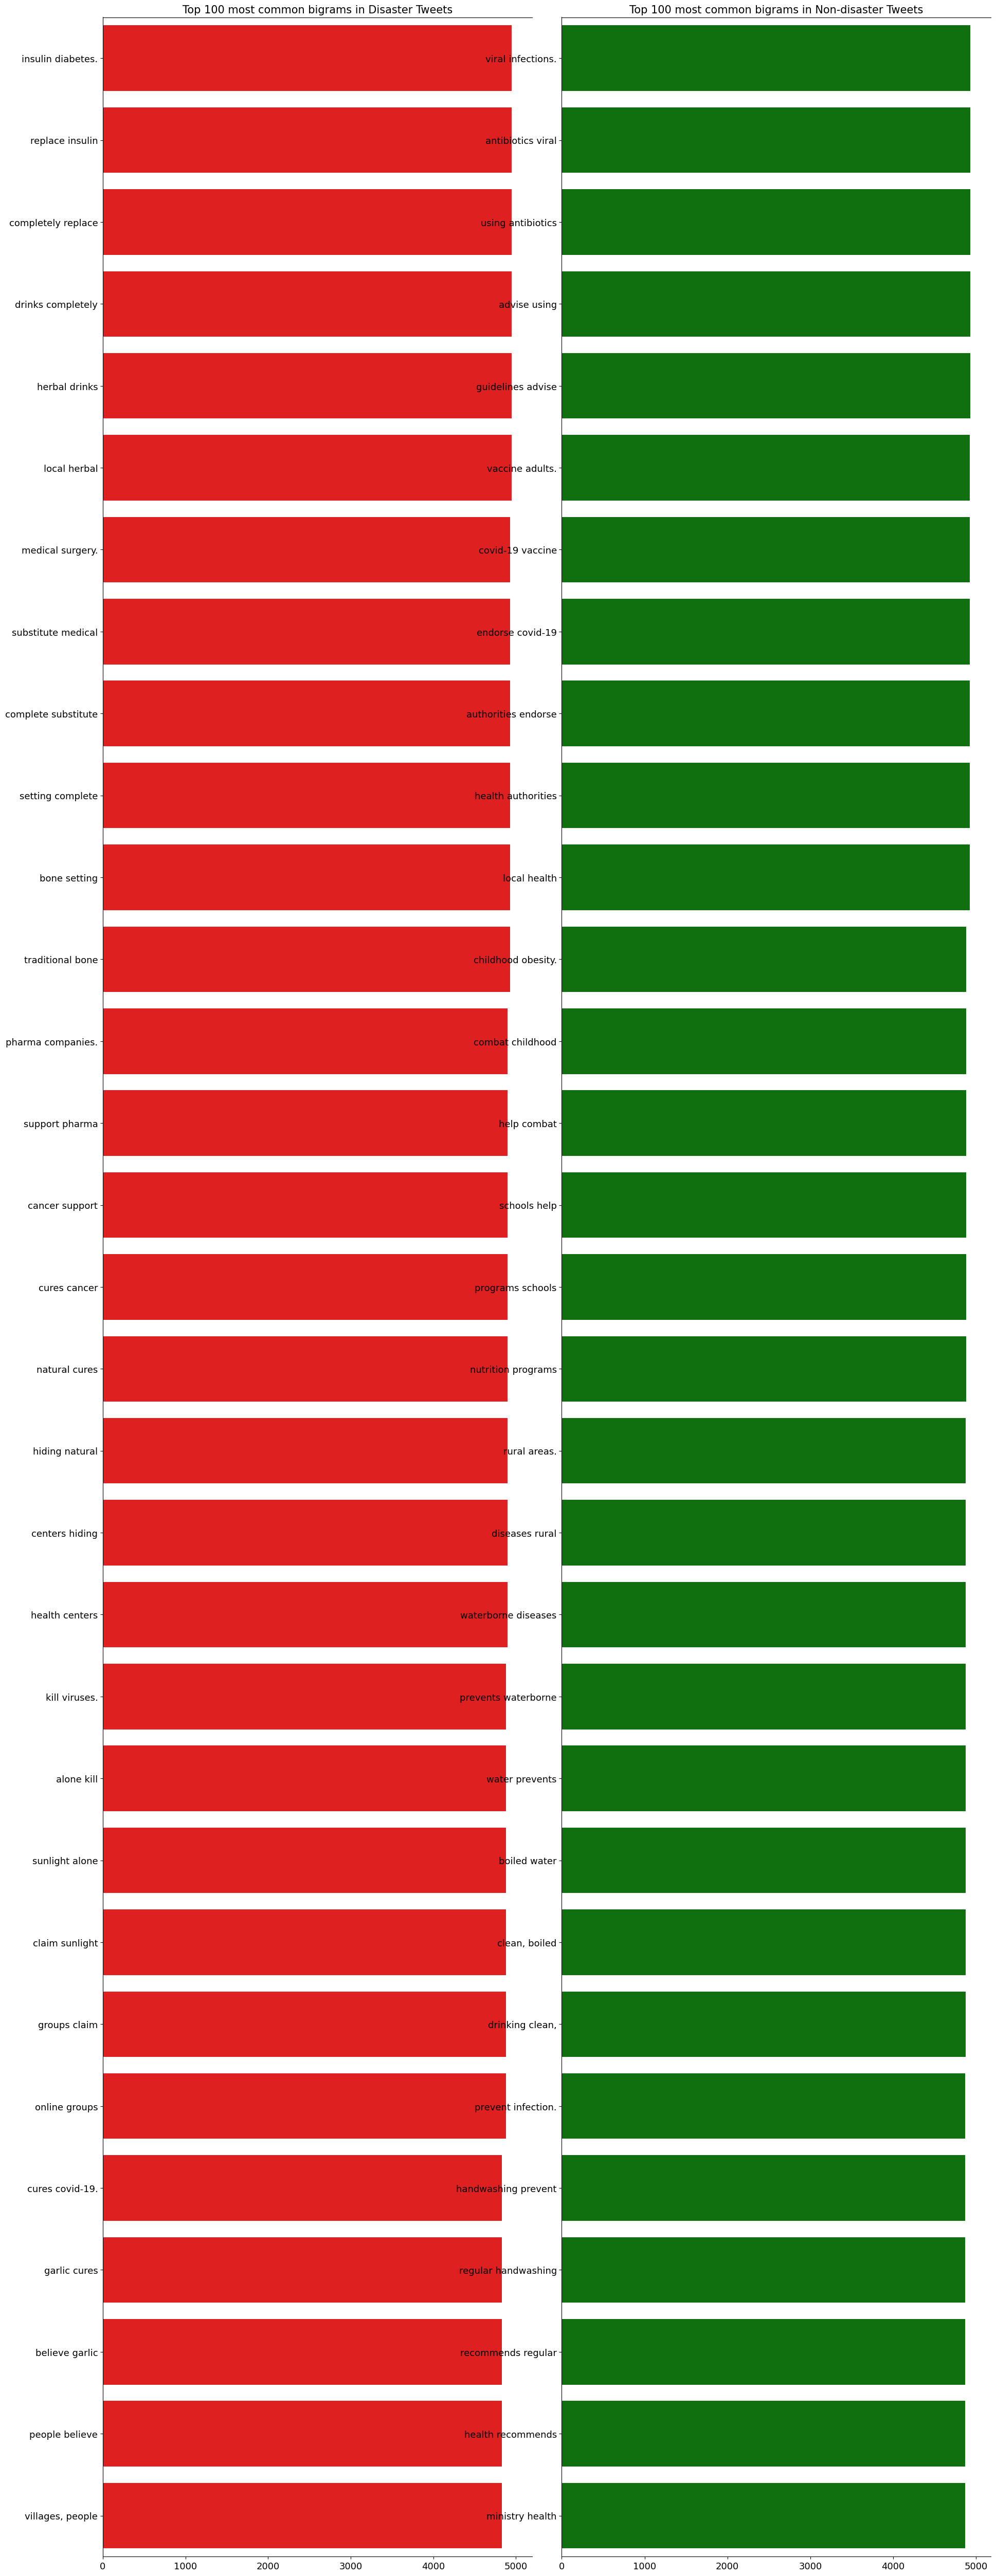

In [26]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_bigrams[0].values[:N], x=df_disaster_bigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_bigrams[0].values[:N], x=df_nondisaster_bigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common bigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Non-disaster Tweets', fontsize=15)

plt.show()


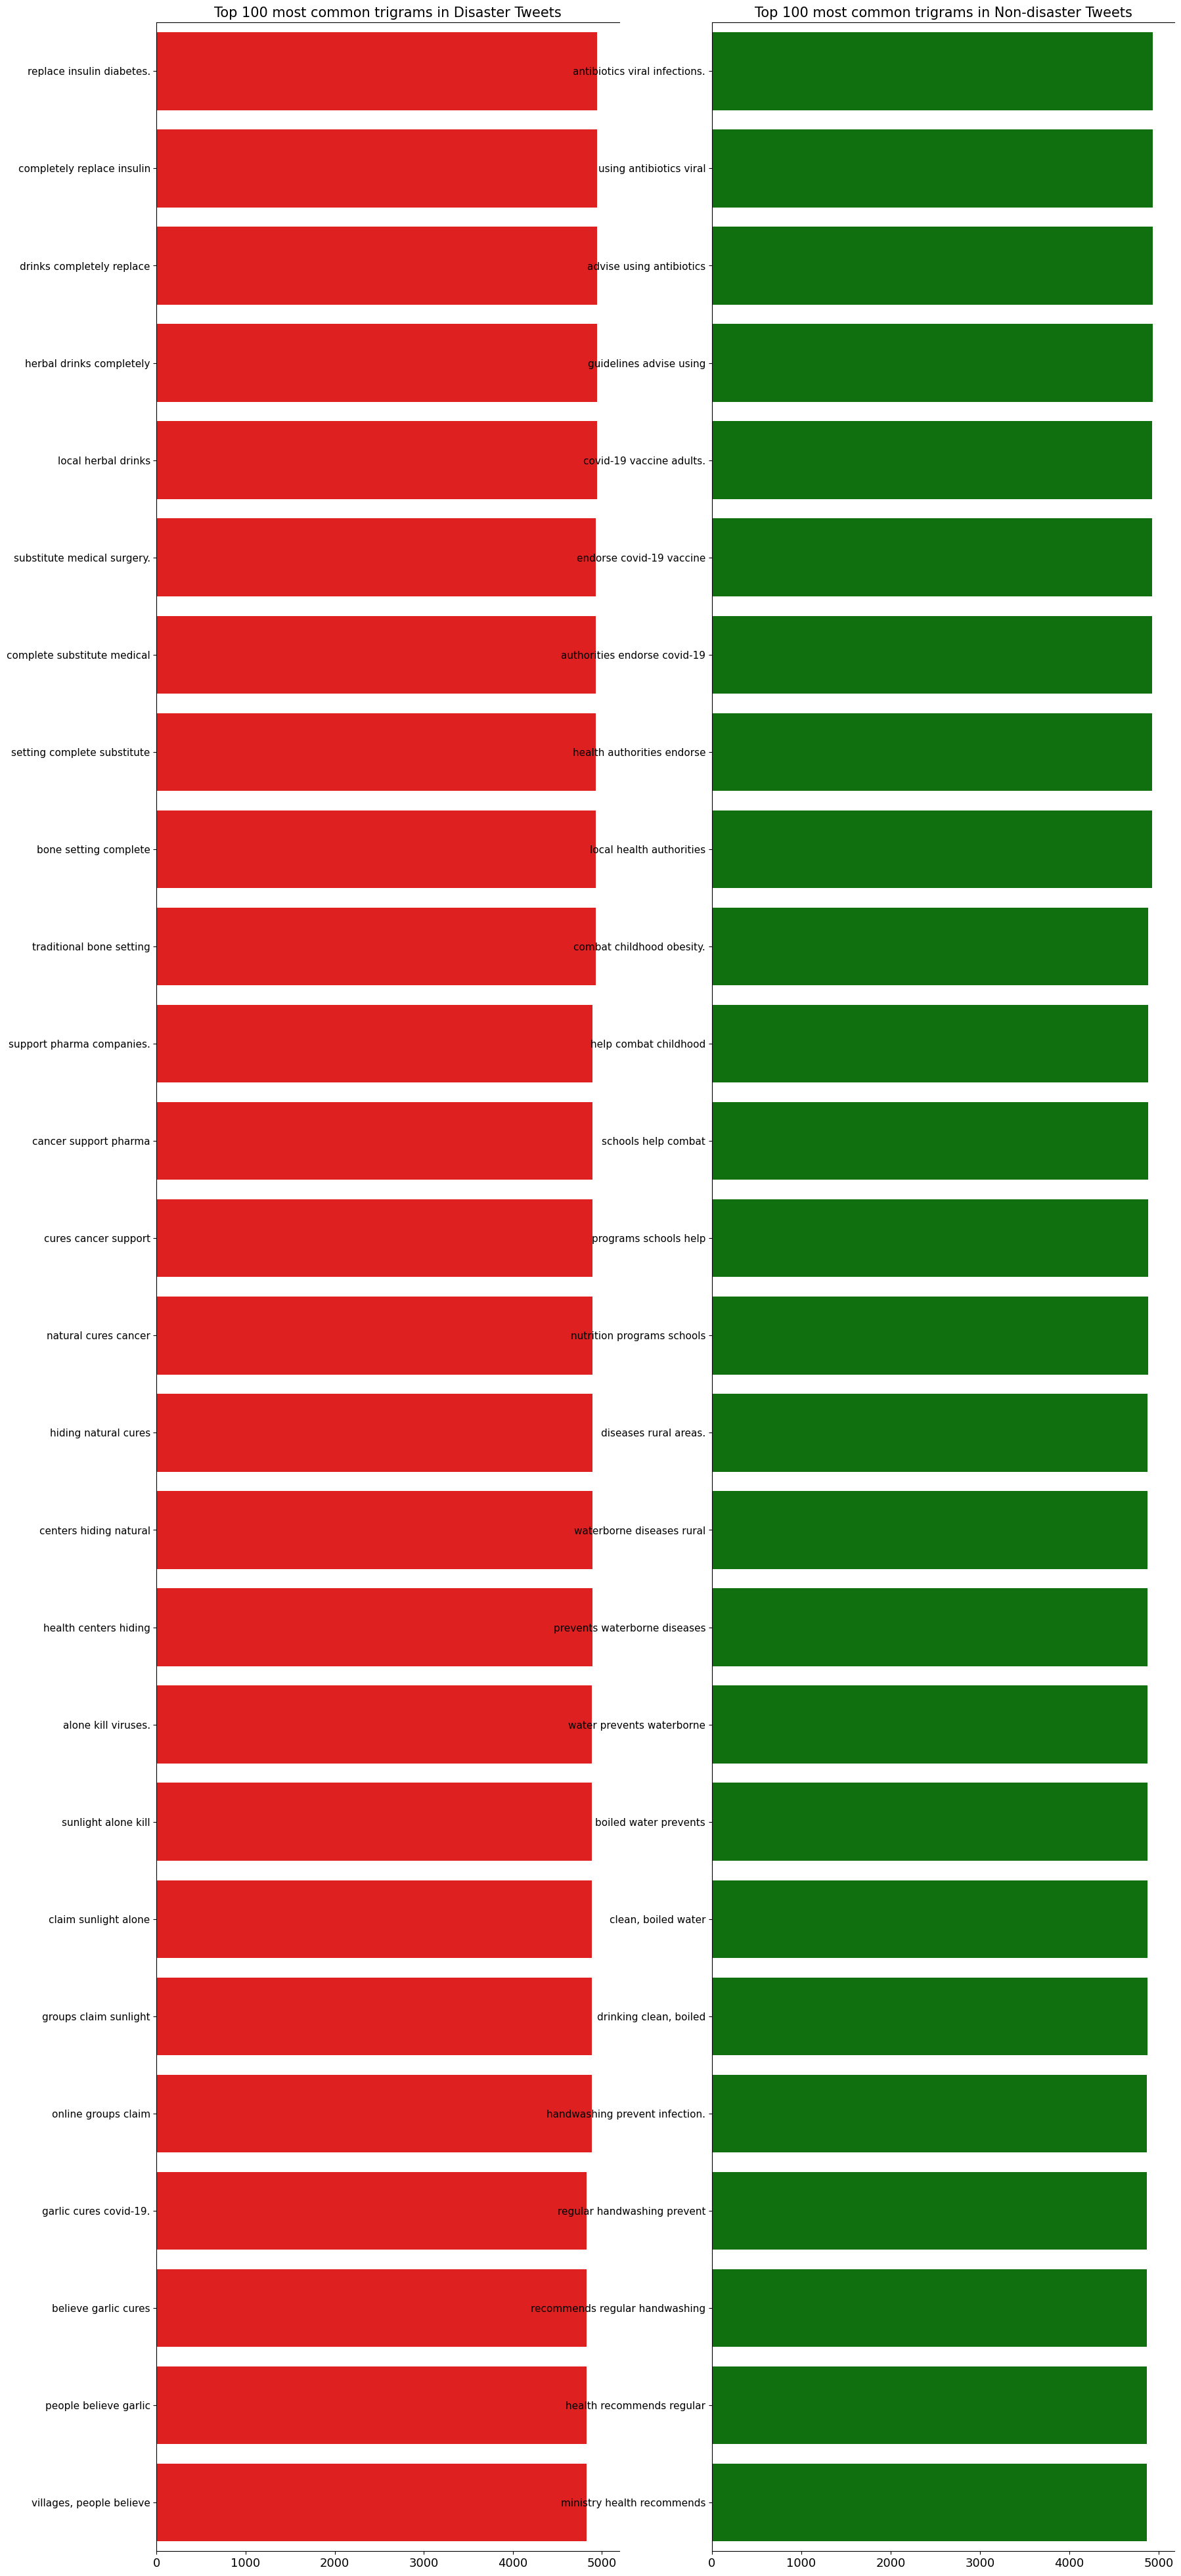

In [27]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 50), dpi=100)

sns.barplot(y=df_disaster_trigrams[0].values[:N], x=df_disaster_trigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_trigrams[0].values[:N], x=df_nondisaster_trigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=11)

axes[0].set_title(f'Top {N} most common trigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common trigrams in Non-disaster Tweets', fontsize=15)

plt.show()


In [28]:
%%time

glove_embeddings = np.load('/content/drive/MyDrive/Health misinformation/glove/glove.840B.300d.pkl', allow_pickle=True)
#fasttext_embeddings = np.load('../input/pickled-crawl300d2m-for-kernel-competitions/crawl-300d-2M.pkl', allow_pickle=True)

CPU times: user 8.78 s, sys: 5.49 s, total: 14.3 s
Wall time: 35.5 s


In [29]:
def build_vocab(X):

    tweets = X.apply(lambda s: s.split()).values
    vocab = {}

    for tweet in tweets:
        for word in tweet:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab


def check_embeddings_coverage(X, embeddings):

    vocab = build_vocab(X)

    covered = {}
    oov = {}
    n_covered = 0
    n_oov = 0

    for word in vocab:
        try:
            covered[word] = embeddings[word]
            n_covered += vocab[word]
        except:
            oov[word] = vocab[word]
            n_oov += vocab[word]

    vocab_coverage = len(covered) / len(vocab)
    text_coverage = (n_covered / (n_covered + n_oov))

    sorted_oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    return sorted_oov, vocab_coverage, text_coverage

train_glove_oov, train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(df_train['Claim'], glove_embeddings)
test_glove_oov, test_glove_vocab_coverage, test_glove_text_coverage = check_embeddings_coverage(df_test['Claim'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_glove_vocab_coverage, train_glove_text_coverage))
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_glove_vocab_coverage, test_glove_text_coverage))



GloVe Embeddings cover 89.53% of vocabulary and 90.74% of text in Training Set
GloVe Embeddings cover 89.53% of vocabulary and 90.65% of text in Test Set


In [ ]:
!pip install -q kaggle


In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aditykhisa123","key":"4ddb6e08fa73579893d40439670298e1"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d authman/pickled-crawl300d2m-for-kernel-competitions

Dataset URL: https://www.kaggle.com/datasets/authman/pickled-crawl300d2m-for-kernel-competitions
License(s): CC-BY-SA-3.0


In [ ]:
!unzip '/content/pickled-crawl300d2m-for-kernel-competitions.zip' -d '/content/drive/MyDrive/Health misinformation/fasttext'

Archive:  /content/pickled-crawl300d2m-for-kernel-competitions.zip
  inflating: /content/drive/MyDrive/Health misinformation/fasttext/crawl-300d-2M.pkl  


In [30]:
fasttext_embeddings = np.load('/content/drive/MyDrive/Health misinformation/fasttext/crawl-300d-2M.pkl', allow_pickle=True)

In [31]:
train_fasttext_oov, train_fasttext_vocab_coverage, train_fasttext_text_coverage = check_embeddings_coverage(df_train['Claim'], fasttext_embeddings)
test_fasttext_oov, test_fasttext_vocab_coverage, test_fasttext_text_coverage = check_embeddings_coverage(df_test['Claim'], fasttext_embeddings)
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_fasttext_vocab_coverage, train_fasttext_text_coverage))
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_fasttext_vocab_coverage, test_fasttext_text_coverage))

FastText Embeddings cover 95.35% of vocabulary and 95.90% of text in Training Set
FastText Embeddings cover 95.35% of vocabulary and 95.79% of text in Test Set


In [32]:
df_mislabeled = df_train.groupby(['Claim']).nunique().sort_values(by='Is Misinformation', ascending=False)
df_mislabeled = df_mislabeled[df_mislabeled['Is Misinformation'] > 1]['Is Misinformation']
df_mislabeled.index.tolist()

[]

In [ ]:
df_train['Claim'].nunique()


10

In [ ]:
df_train.head(15)

,ID,Claim,Is Misinformation,target_mean,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count
7726,3dcc167d-b39d-4bd0-b536-81f0a9124927,Traditional bone setting is a complete substit...,True,0.495934,10,10,3,0,6.100000,70,1,0,0
42200,92fed983-cf16-4a93-a63f-8b67aaa529d5,Traditional bone setting is a complete substit...,True,0.494778,10,10,3,0,6.100000,70,1,0,0
5763,e667ca22-beed-41b5-a1aa-26e969e3263c,Some online groups claim that sunlight alone c...,True,0.500082,11,11,4,0,5.090909,66,1,0,0
60179,ccd93816-df27-4d3e-8b21-26cdfdaae56c,The Ministry of Health recommends regular hand...,False,0.498472,10,10,3,0,6.600000,75,1,0,0
13833,d84a3941-3ede-4973-a9e3-eb7907e36c6b,"In some villages, people believe garlic cures ...",True,0.498931,8,8,2,0,6.000000,55,3,0,0
7199,db0ca7f2-8025-49da-91f7-fc21022fea9d,Nutrition programs in schools help combat chil...,False,0.502225,8,8,1,0,6.625000,60,1,0,0
5580,0e53a5f4-8e8f-4002-aef9-0f4afbc7a417,Local herbal drinks can completely replace ins...,True,0.500568,9,9,2,0,6.222222,64,1,0,0
206,83076908-97c8-49f3-8024-ce1db7d5b4e0,Some online groups claim that sunlight alone c...,True,0.502225,11,11,4,0,5.090909,66,1,0,0
49898,83f6445a-6dd5-4e09-bc92-77639db6c627,Local herbal drinks can completely replace ins...,True,0.498931,9,9,2,0,6.222222,64,1,0,0
54964,4889e49c-ff1e-4306-a242-a6ee798d8e2f,The Ministry of Health recommends regular hand...,False,0.500568,10,10,3,0,6.600000,75,1,0,0


In [ ]:
df_train.tail(15)

,ID,Claim,Is Misinformation,target_mean,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count
4145,d54b4ff6-966a-4839-a708-7fcb038734b6,Local herbal drinks can completely replace ins...,True,0.497790,9,9,2,0,6.222222,64,1,0,0
19137,8093b35a-8905-484d-aaa3-7a22382024e4,"In some villages, people believe garlic cures ...",True,0.507670,8,8,2,0,6.000000,55,3,0,0
13984,c6915453-b6e2-4695-8cbc-4a2124e44290,Local herbal drinks can completely replace ins...,True,0.503607,9,9,2,0,6.222222,64,1,0,0
36854,42c807bf-6a69-433a-8221-3ea30c5ec92f,Nutrition programs in schools help combat chil...,False,0.503607,8,8,1,0,6.625000,60,1,0,0
5175,047f2913-871c-4405-b757-2de254afc58b,WHO guidelines advise against using antibiotic...,False,0.500568,9,9,3,0,6.777778,69,1,0,0
35480,f8b835ff-6825-44fb-8aab-aabcf96d76bd,"Drinking clean, boiled water prevents waterbor...",False,0.500082,10,10,1,0,6.400000,73,2,0,0
21702,4ee42326-d2cc-4a27-bc5d-d2f162e5d285,"Drinking clean, boiled water prevents waterbor...",False,0.507670,10,10,1,0,6.400000,73,2,0,0
53446,565974f0-beea-4757-812c-fae3126462b7,Some online groups claim that sunlight alone c...,True,0.497790,11,11,4,0,5.090909,66,1,0,0
33354,59e3c56f-35ec-4ff4-9fd5-590390a6535a,Traditional bone setting is a complete substit...,True,0.503607,10,10,3,0,6.100000,70,1,0,0
44684,a942d488-5c0a-4be0-bb83-4d6cd357d98c,"Drinking clean, boiled water prevents waterbor...",False,0.502225,10,10,1,0,6.400000,73,2,0,0


Cleaning the corpus

In [33]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [34]:
df_train['Claim'] = df_train['Claim'].apply(lambda x:clean_text(x))


In [35]:
df_train.head()

,ID,Claim,Is Misinformation,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count
7726,3dcc167d-b39d-4bd0-b536-81f0a9124927,traditional bone setting is a complete substit...,True,10,10,3,0,6.100000,70,1,0,0
42200,92fed983-cf16-4a93-a63f-8b67aaa529d5,traditional bone setting is a complete substit...,True,10,10,3,0,6.100000,70,1,0,0
5763,e667ca22-beed-41b5-a1aa-26e969e3263c,some online groups claim that sunlight alone c...,True,11,11,4,0,5.090909,66,1,0,0
60179,ccd93816-df27-4d3e-8b21-26cdfdaae56c,the ministry of health recommends regular hand...,False,10,10,3,0,6.600000,75,1,0,0
13833,d84a3941-3ede-4973-a9e3-eb7907e36c6b,in some villages people believe garlic cures,True,8,8,2,0,6.000000,55,3,0,0


In [40]:
from collections import Counter
!pip install plotly
import plotly.express as px


In [38]:
df_train['temp_list'] = df_train['Claim'].apply(lambda x:str(x).split())
top = Counter([item for sublist in df_train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Claim','count']
temp.style.background_gradient(cmap='Blues')

,Claim,count
0,for,24632
1,health,14692
2,in,14590
3,local,9873
4,can,9832
5,all,9807
6,the,9795
7,to,9768
8,cures,9728
9,some,9714


In [41]:
fig = px.bar(temp, x="count", y="Claim", title='Commmon Words in Selected Text', orientation='h',
             width=700, height=700,color='Claim')
fig.show()

In [44]:
!pip install nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [45]:
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]
df_train['temp_list'] = df_train['temp_list'].apply(lambda x:remove_stopword(x))

In [47]:
top = Counter([item for sublist in df_train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
1,local,9873
2,cures,9728
3,herbal,4949
4,drinks,4949
5,completely,4949
6,replace,4949
7,insulin,4949
8,diabetes,4949
9,guidelines,4934
10,advise,4934


In [60]:
print(df_train['Is Misinformation'].unique())


[ True False]


If values are actual booleans (not strings):

In [61]:
Positive_sent = df_train[df_train['Is Misinformation'] == True]
Negative_sent = df_train[df_train['Is Misinformation'] == False]


In [63]:
#MosT common positive words
top = Counter([item for sublist in Positive_sent['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Claim','Is Misinformation']
temp_positive.style.background_gradient(cmap='Greens')

,Claim,Is Misinformation
0,cures,9728
1,local,4949
2,herbal,4949
3,drinks,4949
4,completely,4949
5,replace,4949
6,insulin,4949
7,diabetes,4949
8,traditional,4928
9,bone,4928


In [64]:
#MosT common negative words
top = Counter([item for sublist in Negative_sent['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

,Common_words,count
1,guidelines,4934
2,advise,4934
3,using,4934
4,antibiotics,4934
5,viral,4934
6,infections,4934
7,local,4924
8,authorities,4924
9,endorse,4924
10,vaccine,4924


In [77]:
def words_unique(misinformation, numwords, raw_words):
    '''
    Input:
        misinformation - Misinformation category (True or False);
        numwords - how many specific words do you want to see in the final result;
        raw_words - list for item in train_data[train_data.segments == segments]['temp_list1']:
    Output:
        dataframe giving information about the name of the specific ingredient and how many times it occurs in the chosen cuisine (in descending order based on their counts).

    '''
    allother = []
    for item in df_train[df_train['Is Misinformation'] != misinformation]['temp_list1']:
        for word in item:
            allother.append(word)
    allother = list(set(allother))

    specificnonly = [x for x in raw_text if x not in allother]

    mycounter = Counter()

    for item in df_train[df_train['Is Misinformation'] == misinformation]['temp_list1']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)

    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]

    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns=['words', 'count'])

    return Unique_words

In [67]:
!pip install palettable
from palettable.colorbrewer.qualitative import Pastel1_7

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 4.9 MB/s eta 0:00:00


In [71]:
df_train['temp_list1'] = df_train['Claim'].apply(lambda x:str(x).split()) #List of words in every row for text
df_train['temp_list1'] = df_train['temp_list1'].apply(lambda x:remove_stopword(x)) #Removing Stopwords

In [78]:
raw_text = [word for word_list in df_train['temp_list1'] for word in word_list]
Unique_Positive= words_unique(True, 20, raw_text)

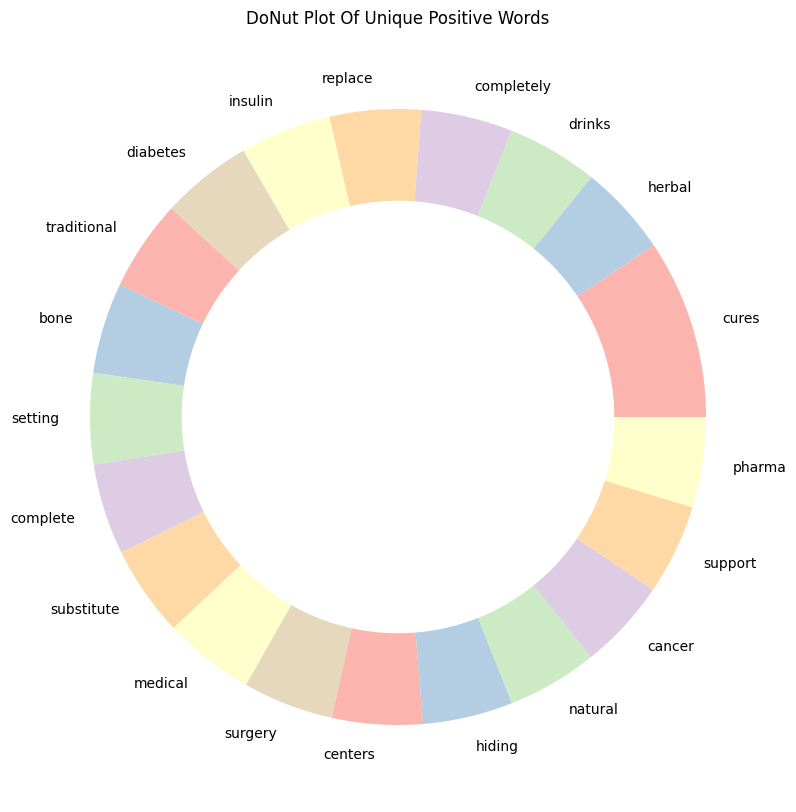

In [79]:
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Positive['count'], labels=Unique_Positive.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Positive Words')
plt.show()

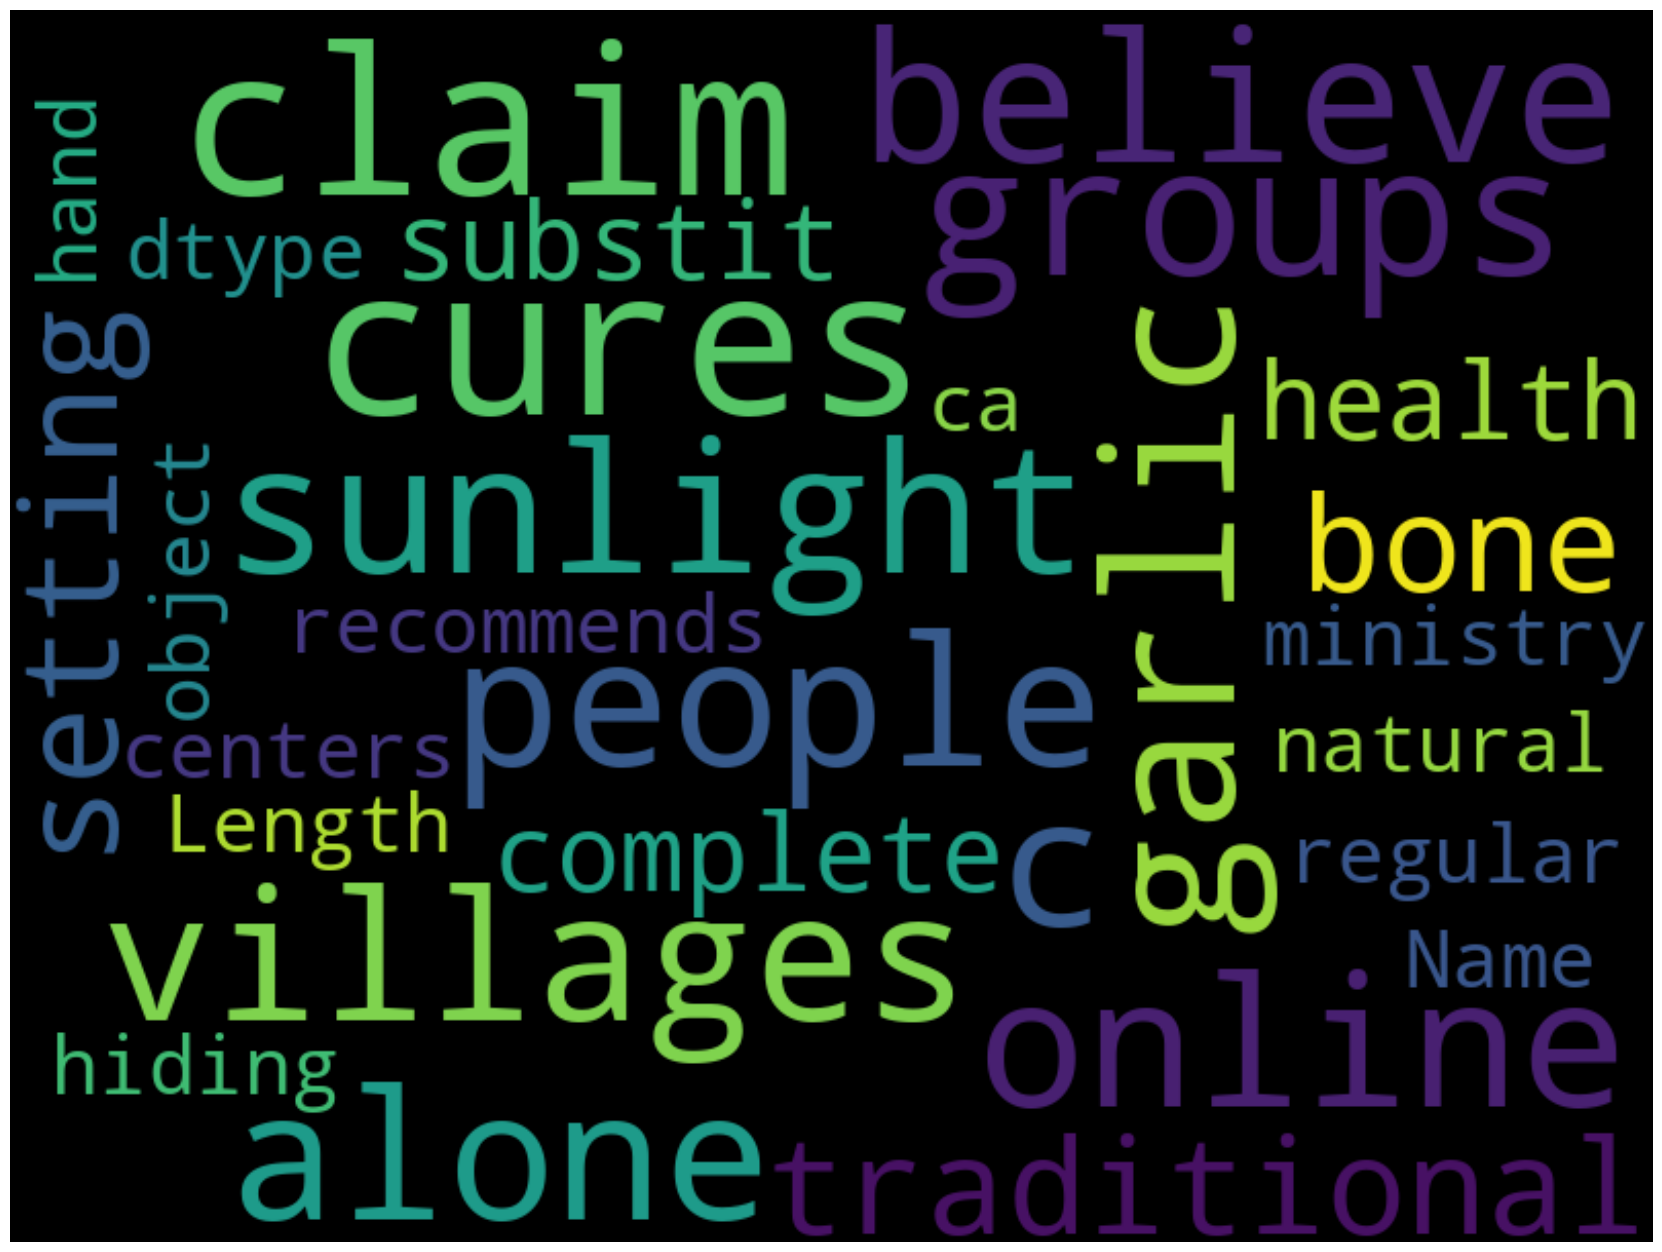

In [85]:
from wordcloud import WordCloud, STOPWORDS
import numpy as np
import matplotlib.pyplot as plt

# Function to plot wordcloud
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100,
                   figure_size=(24.0,16.0),
                   title=None, title_size=40, image_color=False):

    stopwords = set(STOPWORDS)
    more_stopwords = {'u', "im"}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=max_words,
        max_font_size=max_font_size,
        random_state=42,
        width=800,              # Set canvas width
        height=600,             # Set canvas height
        mask=mask
    ).generate(str(text))

    plt.figure(figsize=figure_size)
    if image_color and mask is not None:
        from wordcloud import ImageColorGenerator
        image_colors = ImageColorGenerator(mask)
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
    else:
        plt.imshow(wordcloud, interpolation="bilinear")

    plt.axis('off')
    if title:
        plt.title(title, fontsize=title_size)
    plt.show()

#Fixed the indentation issue by aligning the call to `plot_wordcloud()`
#with the function definition, ensuring proper indentation.
plot_wordcloud(df_train['Claim']) #Pass the desired text data to the function

Using the nltk for remove stopwords

In [87]:
remove_stopword(df_train['Claim'])

['traditional bone setting is a complete substitute for medical surgery',
 'traditional bone setting is a complete substitute for medical surgery',
 'some online groups claim that sunlight alone can kill all viruses',
 'the ministry of health recommends regular handwashing to prevent infection',
 'in some villages people believe garlic cures ',
 'nutrition programs in schools help combat childhood obesity',
 'local herbal drinks can completely replace insulin for diabetes',
 'some online groups claim that sunlight alone can kill all viruses',
 'local herbal drinks can completely replace insulin for diabetes',
 'the ministry of health recommends regular handwashing to prevent infection',
 'local health authorities endorse the  vaccine for all adults',
 'the ministry of health recommends regular handwashing to prevent infection',
 'drinking clean boiled water prevents waterborne diseases in rural areas',
 'in some villages people believe garlic cures ',
 'in some villages people believe 

In [88]:
import spacy
nlp = spacy.load("en_core_web_sm")
stop_words = nlp.Defaults.stop_words


Using spacy for removing stopwords

In [89]:
def remove_spacy_stopwords(text):
    return ' '.join([token.text for token in nlp(str(text)) if not token.is_stop and not token.is_punct])

df_train['cleaned_claim'] = df_train['Claim'].apply(remove_spacy_stopwords)


In [90]:
df_train['cleaned_claim']

,cleaned_claim
7726,traditional bone setting complete substitute m...
42200,traditional bone setting complete substitute m...
5763,online groups claim sunlight kill viruses
60179,ministry health recommends regular handwashing...
13833,villages people believe garlic cures
...,...
11340,health centers hiding natural cures cancer sup...
57709,online groups claim sunlight kill viruses
50786,villages people believe garlic cures
38407,online groups claim sunlight kill viruses


In [91]:
df_train['Claim']=df_train['cleaned_claim']

In [92]:
df_train

,ID,Claim,Is Misinformation,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count,temp_list,temp_list1,cleaned_claim
7726,3dcc167d-b39d-4bd0-b536-81f0a9124927,traditional bone setting complete substitute m...,True,10,10,3,0,6.100000,70,1,0,0,"[traditional, bone, setting, complete, substit...","[traditional, bone, setting, complete, substit...",traditional bone setting complete substitute m...
42200,92fed983-cf16-4a93-a63f-8b67aaa529d5,traditional bone setting complete substitute m...,True,10,10,3,0,6.100000,70,1,0,0,"[traditional, bone, setting, complete, substit...","[traditional, bone, setting, complete, substit...",traditional bone setting complete substitute m...
5763,e667ca22-beed-41b5-a1aa-26e969e3263c,online groups claim sunlight kill viruses,True,11,11,4,0,5.090909,66,1,0,0,"[online, groups, claim, sunlight, alone, kill,...","[online, groups, claim, sunlight, alone, kill,...",online groups claim sunlight kill viruses
60179,ccd93816-df27-4d3e-8b21-26cdfdaae56c,ministry health recommends regular handwashing...,False,10,10,3,0,6.600000,75,1,0,0,"[ministry, health, recommends, regular, handwa...","[ministry, health, recommends, regular, handwa...",ministry health recommends regular handwashing...
13833,d84a3941-3ede-4973-a9e3-eb7907e36c6b,villages people believe garlic cures,True,8,8,2,0,6.000000,55,3,0,0,"[villages, people, believe, garlic, cures]","[villages, people, believe, garlic, cures]",villages people believe garlic cures
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11340,3386bb0e-213a-4a9b-a334-df849a0b5d0b,health centers hiding natural cures cancer sup...,True,12,12,3,0,5.666667,79,1,0,0,"[health, centers, hiding, natural, cures, canc...","[health, centers, hiding, natural, cures, canc...",health centers hiding natural cures cancer sup...
57709,6d30b365-02a5-4b62-8725-489b1311e9e3,online groups claim sunlight kill viruses,True,11,11,4,0,5.090909,66,1,0,0,"[online, groups, claim, sunlight, alone, kill,...","[online, groups, claim, sunlight, alone, kill,...",online groups claim sunlight kill viruses
50786,6cf56c1c-39e0-4acb-bf16-43426e419025,villages people believe garlic cures,True,8,8,2,0,6.000000,55,3,0,0,"[villages, people, believe, garlic, cures]","[villages, people, believe, garlic, cures]",villages people believe garlic cures
38407,fe36ab37-78e5-4c0b-bbb0-87ec23062a4e,online groups claim sunlight kill viruses,True,11,11,4,0,5.090909,66,1,0,0,"[online, groups, claim, sunlight, alone, kill,...","[online, groups, claim, sunlight, alone, kill,...",online groups claim sunlight kill viruses


In [95]:
K = 2
skf = StratifiedKFold(n_splits=K, random_state=SEED, shuffle=True)
df_train['target_relabeled'] = df_train['Is Misinformation'].copy()
DISASTER = df_train['Is Misinformation'] == 1
print('Whole Training Set Shape = {}'.format(df_train.shape))
print('Whole Training Set Unique keyword Count = {}'.format(df_train['Claim'].nunique()))
print('Whole Training Set Target Rate (Disaster) {}/{} (Not Disaster)'.format(df_train[DISASTER]['target_relabeled'].count(), df_train[~DISASTER]['target_relabeled'].count()))

for fold, (trn_idx, val_idx) in enumerate(skf.split(df_train['Claim'], df_train['Is Misinformation']), 1):
    print('\nFold {} Training Set Shape = {} - Validation Set Shape = {}'.format(fold, df_train.loc[trn_idx, 'Claim'].shape, df_train.loc[val_idx, 'Claim'].shape))
    print('Fold {} Training Set Unique keyword Count = {} - Validation Set Unique keyword Count = {}'.format(fold, df_train.loc[trn_idx, 'Claim'].nunique(), df_train.loc[val_idx, 'Claim'].nunique()))

Whole Training Set Shape = (48976, 16)
Whole Training Set Unique keyword Count = 10
Whole Training Set Target Rate (Disaster) 24488/24488 (Not Disaster)


KeyError: '[19, 22, 29, 47, 59, 87, 90, 91, 98, 111, 112, 118, 120, 131, 141, 148, 155, 162, 169, 175, 188, 203, 213, 221, 241, 253, 256, 264, 267, 273, 287, 298, 303, 308, 314, 319, 326, 332, 339, 342, 344, 346, 356, 373, 389, 390, 392, 394, 395, 398, 399, 401, 419, 420, 422, 425, 426, 434, 438, 445, 447, 451, 465, 476, 478, 506, 508, 518, 535, 537, 542, 585, 586, 591, 597, 603, 606, 608, 627, 639, 661, 687, 690, 691, 693, 704, 705, 711, 724, 731, 735, 739, 748, 765, 782, 790, 795, 800, 809, 821, 848, 860, 882, 891, 892, 899, 906, 924, 974, 975, 987, 989, 1023, 1029, 1046, 1058, 1061, 1069, 1070, 1074, 1076, 1112, 1124, 1139, 1148, 1149, 1162, 1163, 1169, 1174, 1180, 1185, 1187, 1197, 1222, 1247, 1259, 1262, 1282, 1287, 1296, 1307, 1314, 1316, 1321, 1325, 1344, 1349, 1352, 1354, 1364, 1365, 1366, 1371, 1380, 1382, 1390, 1393, 1400, 1414, 1419, 1428, 1432, 1434, 1448, 1453, 1472, 1487, 1504, 1508, 1549, 1577, 1582, 1587, 1597, 1599, 1602, 1603, 1606, 1607, 1622, 1634, 1643, 1652, 1668, 1674, 1680, 1705, 1711, 1716, 1719, 1723, 1735, 1737, 1744, 1765, 1769, 1770, 1785, 1788, 1815, 1821, 1832, 1834, 1906, 1923, 1930, 1940, 1942, 1943, 1959, 1968, 1977, 1994, 2026, 2035, 2055, 2057, 2061, 2073, 2120, 2129, 2130, 2131, 2132, 2135, 2146, 2147, 2157, 2158, 2164, 2166, 2178, 2200, 2220, 2224, 2273, 2274, 2276, 2284, 2303, 2306, 2309, 2324, 2346, 2353, 2367, 2377, 2382, 2392, 2408, 2410, 2411, 2416, 2417, 2421, 2427, 2437, 2445, 2446, 2462, 2464, 2492, 2507, 2508, 2516, 2517, 2542, 2552, 2562, 2576, 2587, 2610, 2628, 2633, 2642, 2650, 2655, 2658, 2684, 2685, 2694, 2714, 2736, 2742, 2749, 2755, 2758, 2774, 2819, 2832, 2856, 2885, 2890, 2900, 2903, 2942, 2950, 2954, 2966, 3010, 3017, 3021, 3026, 3029, 3046, 3056, 3060, 3064, 3067, 3074, 3079, 3088, 3102, 3127, 3131, 3135, 3139, 3143, 3168, 3174, 3176, 3188, 3204, 3212, 3216, 3217, 3218, 3219, 3224, 3226, 3240, 3252, 3253, 3258, 3259, 3266, 3267, 3293, 3312, 3318, 3323, 3355, 3356, 3357, 3362, 3365, 3370, 3385, 3392, 3394, 3398, 3407, 3416, 3426, 3438, 3467, 3471, 3474, 3476, 3479, 3484, 3490, 3492, 3498, 3517, 3518, 3533, 3555, 3576, 3593, 3602, 3607, 3617, 3637, 3653, 3655, 3664, 3668, 3670, 3671, 3672, 3686, 3696, 3697, 3703, 3706, 3732, 3760, 3777, 3793, 3807, 3814, 3822, 3825, 3830, 3835, 3836, 3840, 3841, 3848, 3867, 3888, 3910, 3914, 3920, 3931, 3935, 3941, 3947, 3949, 3956, 3960, 3969, 3973, 3978, 3981, 3987, 3994, 3998, 4008, 4012, 4014, 4021, 4024, 4032, 4034, 4035, 4056, 4070, 4079, 4087, 4100, 4104, 4120, 4139, 4165, 4171, 4177, 4178, 4181, 4182, 4183, 4186, 4189, 4197, 4207, 4255, 4256, 4272, 4282, 4287, 4302, 4304, 4325, 4334, 4335, 4338, 4348, 4359, 4362, 4373, 4389, 4399, 4450, 4486, 4511, 4518, 4519, 4545, 4546, 4550, 4552, 4570, 4583, 4607, 4612, 4622, 4649, 4672, 4675, 4676, 4684, 4690, 4706, 4715, 4719, 4734, 4742, 4768, 4791, 4793, 4797, 4805, 4806, 4818, 4831, 4838, 4845, 4846, 4847, 4849, 4855, 4860, 4877, 4886, 4889, 4901, 4906, 4918, 4922, 4923, 4930, 4947, 4950, 4983, 4991, 5025, 5041, 5049, 5055, 5060, 5080, 5087, 5103, 5115, 5117, 5124, 5128, 5135, 5137, 5151, 5153, 5158, 5181, 5183, 5189, 5210, 5232, 5248, 5252, 5298, 5306, 5309, 5322, 5324, 5336, 5355, 5357, 5366, 5370, 5372, 5387, 5400, 5408, 5409, 5423, 5424, 5431, 5455, 5458, 5474, 5481, 5482, 5484, 5493, 5504, 5510, 5522, 5524, 5536, 5565, 5569, 5573, 5575, 5603, 5627, 5629, 5634, 5640, 5646, 5652, 5658, 5660, 5663, 5674, 5684, 5692, 5697, 5713, 5719, 5721, 5735, 5751, 5752, 5760, 5791, 5820, 5823, 5836, 5847, 5865, 5874, 5880, 5903, 5910, 5914, 5916, 5918, 5922, 5927, 5939, 5958, 5963, 5977, 5998, 6009, 6025, 6029, 6033, 6058, 6071, 6093, 6100, 6105, 6106, 6119, 6163, 6179, 6183, 6205, 6213, 6217, 6223, 6224, 6227, 6231, 6233, 6234, 6246, 6254, 6257, 6268, 6276, 6292, 6293, 6309, 6313, 6327, 6334, 6346, 6362, 6369, 6372, 6376, 6383, 6385, 6412, 6413, 6434, 6439, 6454, 6456, 6460, 6463, 6464, 6469, 6480, 6481, 6484, 6524, 6555, 6569, 6597, 6600, 6610, 6615, 6618, 6622, 6635, 6667, 6690, 6691, 6693, 6697, 6705, 6710, 6751, 6752, 6766, 6774, 6776, 6779, 6794, 6806, 6807, 6812, 6817, 6842, 6844, 6851, 6862, 6877, 6882, 6894, 6919, 6940, 6949, 6978, 6980, 6990, 7037, 7047, 7054, 7082, 7095, 7097, 7101, 7119, 7122, 7146, 7154, 7160, 7176, 7186, 7201, 7208, 7217, 7225, 7232, 7267, 7280, 7294, 7315, 7319, 7324, 7335, 7336, 7343, 7359, 7375, 7376, 7377, 7385, 7396, 7398, 7401, 7407, 7411, 7418, 7427, 7450, 7456, 7460, 7469, 7474, 7479, 7493, 7495, 7502, 7511, 7539, 7546, 7554, 7564, 7567, 7577, 7586, 7587, 7595, 7604, 7614, 7619, 7621, 7640, 7646, 7668, 7684, 7685, 7687, 7689, 7722, 7734, 7766, 7769, 7770, 7794, 7803, 7820, 7874, 7879, 7882, 7902, 7906, 7911, 7925, 7927, 7942, 7949, 7962, 7972, 7992, 8018, 8020, 8022, 8027, 8082, 8085, 8089, 8106, 8130, 8139, 8150, 8154, 8164, 8193, 8202, 8214, 8215, 8217, 8227, 8232, 8248, 8254, 8255, 8257, 8260, 8272, 8296, 8301, 8322, 8328, 8344, 8346, 8348, 8350, 8354, 8396, 8400, 8412, 8419, 8422, 8435, 8442, 8444, 8465, 8472, 8475, 8539, 8558, 8564, 8570, 8592, 8596, 8599, 8622, 8643, 8644, 8649, 8675, 8682, 8684, 8696, 8703, 8704, 8716, 8721, 8723, 8725, 8739, 8749, 8762, 8774, 8777, 8778, 8792, 8798, 8799, 8801, 8809, 8810, 8811, 8841, 8842, 8848, 8849, 8883, 8886, 8887, 8899, 8902, 8903, 8905, 8928, 8949, 8952, 8955, 8958, 8967, 8968, 8971, 8986, 8989, 9006, 9013, 9018, 9019, 9029, 9032, 9034, 9048, 9050, 9073, 9091, 9094, 9098, 9139, 9144, 9146, 9156, 9166, 9169, 9170, 9176, 9177, 9237, 9253, 9255, 9257, 9271, 9313, 9319, 9326, 9330, 9332, 9359, 9360, 9365, 9366, 9368, 9374, 9386, 9388, 9391, 9398, 9400, 9420, 9423, 9482, 9488, 9491, 9493, 9505, 9508, 9515, 9521, 9523, 9537, 9540, 9545, 9559, 9568, 9585, 9591, 9597, 9618, 9625, 9626, 9627, 9631, 9658, 9668, 9674, 9719, 9729, 9730, 9735, 9775, 9776, 9783, 9792, 9796, 9798, 9801, 9820, 9823, 9830, 9836, 9880, 9885, 9898, 9899, 9911, 9922, 9936, 9938, 9945, 9946, 9947, 9960, 9968, 9978, 10023, 10025, 10029, 10031, 10033, 10037, 10038, 10047, 10060, 10061, 10066, 10069, 10081, 10099, 10107, 10121, 10150, 10155, 10171, 10173, 10184, 10189, 10196, 10228, 10230, 10255, 10263, 10279, 10288, 10299, 10305, 10311, 10322, 10333, 10366, 10389, 10409, 10413, 10414, 10422, 10423, 10428, 10442, 10465, 10471, 10476, 10487, 10501, 10503, 10505, 10534, 10547, 10551, 10571, 10603, 10620, 10624, 10654, 10670, 10677, 10697, 10706, 10707, 10716, 10717, 10740, 10741, 10749, 10752, 10777, 10780, 10781, 10785, 10797, 10798, 10802, 10806, 10811, 10818, 10832, 10839, 10845, 10851, 10859, 10863, 10871, 10876, 10883, 10892, 10921, 10933, 10952, 10963, 10967, 10984, 10999, 11011, 11019, 11024, 11043, 11048, 11054, 11055, 11058, 11068, 11093, 11102, 11106, 11127, 11147, 11169, 11174, 11177, 11182, 11187, 11191, 11204, 11205, 11207, 11209, 11223, 11241, 11259, 11264, 11266, 11295, 11303, 11314, 11343, 11353, 11354, 11360, 11368, 11372, 11373, 11386, 11403, 11415, 11424, 11428, 11455, 11483, 11510, 11514, 11523, 11531, 11543, 11561, 11565, 11595, 11606, 11613, 11637, 11638, 11642, 11651, 11659, 11664, 11670, 11685, 11711, 11720, 11738, 11741, 11744, 11752, 11755, 11758, 11768, 11772, 11775, 11791, 11798, 11823, 11825, 11833, 11843, 11845, 11853, 11855, 11858, 11882, 11888, 11924, 11930, 11943, 11946, 11951, 11953, 11960, 11961, 11962, 11970, 12042, 12049, 12063, 12069, 12075, 12081, 12086, 12094, 12096, 12113, 12114, 12115, 12127, 12133, 12154, 12159, 12201, 12217, 12222, 12239, 12245, 12248, 12258, 12290, 12309, 12335, 12351, 12354, 12365, 12374, 12418, 12424, 12439, 12453, 12459, 12461, 12465, 12468, 12475, 12491, 12498, 12504, 12521, 12522, 12537, 12551, 12552, 12553, 12561, 12572, 12579, 12585, 12596, 12603, 12605, 12625, 12636, 12644, 12652, 12655, 12656, 12657, 12660, 12664, 12676, 12677, 12688, 12731, 12743, 12751, 12774, 12780, 12784, 12791, 12795, 12800, 12848, 12851, 12858, 12876, 12890, 12891, 12901, 12902, 12907, 12980, 12981, 12984, 13005, 13022, 13025, 13032, 13039, 13055, 13058, 13068, 13072, 13074, 13075, 13076, 13085, 13086, 13097, 13099, 13109, 13116, 13131, 13145, 13147, 13169, 13207, 13215, 13218, 13219, 13220, 13239, 13242, 13244, 13256, 13263, 13264, 13266, 13274, 13292, 13300, 13335, 13342, 13346, 13349, 13372, 13375, 13389, 13403, 13413, 13416, 13419, 13456, 13465, 13468, 13476, 13478, 13482, 13491, 13496, 13504, 13533, 13554, 13561, 13580, 13598, 13613, 13616, 13619, 13631, 13635, 13641, 13647, 13670, 13689, 13706, 13708, 13712, 13713, 13716, 13725, 13732, 13735, 13739, 13752, 13799, 13816, 13819, 13822, 13825, 13832, 13837, 13840, 13842, 13849, 13854, 13860, 13864, 13870, 13874, 13885, 13890, 13891, 13892, 13899, 13903, 13908, 13926, 13931, 13943, 13947, 13956, 13961, 13970, 14008, 14011, 14014, 14016, 14021, 14023, 14043, 14075, 14076, 14080, 14081, 14111, 14114, 14136, 14149, 14178, 14185, 14188, 14193, 14201, 14229, 14237, 14239, 14240, 14246, 14251, 14254, 14255, 14277, 14284, 14285, 14287, 14290, 14313, 14318, 14320, 14376, 14391, 14396, 14405, 14417, 14418, 14429, 14460, 14466, 14474, 14483, 14485, 14516, 14524, 14534, 14536, 14560, 14561, 14601, 14602, 14614, 14615, 14625, 14660, 14671, 14682, 14686, 14700, 14711, 14728, 14744, 14764, 14769, 14775, 14776, 14780, 14801, 14812, 14823, 14830, 14838, 14867, 14869, 14874, 14875, 14877, 14881, 14890, 14895, 14900, 14903, 14908, 14917, 14955, 14958, 14961, 14971, 15009, 15016, 15021, 15032, 15040, 15043, 15066, 15084, 15091, 15094, 15098, 15113, 15130, 15131, 15139, 15140, 15143, 15144, 15149, 15159, 15182, 15187, 15192, 15223, 15254, 15255, 15289, 15292, 15302, 15331, 15347, 15366, 15384, 15386, 15391, 15400, 15404, 15424, 15426, 15455, 15464, 15500, 15536, 15537, 15542, 15544, 15548, 15550, 15554, 15565, 15584, 15591, 15600, 15605, 15612, 15615, 15619, 15627, 15651, 15657, 15667, 15676, 15688, 15691, 15706, 15727, 15744, 15760, 15775, 15779, 15789, 15792, 15798, 15804, 15830, 15835, 15836, 15855, 15858, 15863, 15867, 15878, 15881, 15884, 15887, 15891, 15900, 15904, 15906, 15908, 15909, 15923, 15944, 15962, 15966, 15979, 15991, 15996, 16005, 16014, 16027, 16029, 16035, 16040, 16048, 16082, 16086, 16093, 16096, 16106, 16119, 16128, 16135, 16147, 16153, 16154, 16168, 16193, 16196, 16197, 16205, 16239, 16240, 16244, 16245, 16250, 16293, 16297, 16299, 16302, 16310, 16318, 16329, 16340, 16356, 16359, 16373, 16380, 16381, 16394, 16395, 16398, 16400, 16402, 16416, 16423, 16425, 16431, 16444, 16454, 16459, 16461, 16464, 16478, 16493, 16501, 16505, 16506, 16507, 16508, 16533, 16535, 16537, 16547, 16552, 16561, 16566, 16572, 16574, 16589, 16590, 16596, 16601, 16631, 16635, 16642, 16648, 16651, 16660, 16675, 16685, 16710, 16712, 16736, 16737, 16748, 16792, 16793, 16815, 16837, 16854, 16856, 16865, 16868, 16869, 16875, 16902, 16915, 16939, 16941, 16966, 16976, 16978, 16998, 17003, 17027, 17028, 17036, 17039, 17046, 17050, 17052, 17057, 17077, 17089, 17092, 17098, 17116, 17127, 17154, 17157, 17185, 17203, 17206, 17214, 17235, 17247, 17258, 17266, 17275, 17278, 17280, 17283, 17302, 17304, 17307, 17314, 17318, 17320, 17323, 17327, 17330, 17353, 17356, 17361, 17362, 17364, 17373, 17400, 17429, 17451, 17466, 17467, 17480, 17502, 17508, 17512, 17515, 17519, 17541, 17556, 17571, 17610, 17613, 17637, 17648, 17693, 17694, 17714, 17734, 17739, 17741, 17754, 17769, 17771, 17789, 17800, 17825, 17829, 17834, 17863, 17893, 17917, 17918, 17920, 17943, 17945, 17947, 17952, 17961, 17984, 17992, 18001, 18005, 18050, 18054, 18061, 18062, 18072, 18076, 18085, 18107, 18132, 18150, 18158, 18159, 18166, 18171, 18185, 18191, 18223, 18226, 18239, 18248, 18256, 18264, 18265, 18272, 18289, 18290, 18315, 18317, 18329, 18349, 18350, 18388, 18394, 18398, 18410, 18472, 18475, 18482, 18492, 18548, 18573, 18575, 18593, 18594, 18597, 18603, 18604, 18637, 18646, 18691, 18701, 18751, 18759, 18767, 18772, 18773, 18775, 18779, 18788, 18795, 18802, 18810, 18817, 18831, 18890, 18909, 18916, 18925, 18939, 18940, 18943, 18946, 18954, 18968, 18976, 18978, 18981, 18996, 19003, 19011, 19042, 19066, 19078, 19095, 19096, 19102, 19108, 19115, 19166, 19169, 19195, 19202, 19207, 19218, 19221, 19226, 19230, 19250, 19258, 19262, 19271, 19273, 19301, 19315, 19318, 19327, 19328, 19357, 19402, 19413, 19416, 19426, 19451, 19460, 19461, 19465, 19471, 19472, 19474, 19508, 19525, 19548, 19550, 19552, 19559, 19563, 19565, 19584, 19605, 19611, 19614, 19615, 19618, 19631, 19638, 19652, 19664, 19681, 19693, 19698, 19705, 19709, 19714, 19721, 19762, 19778, 19782, 19792, 19796, 19805, 19820, 19832, 19849, 19857, 19873, 19888, 19911, 19913, 19915, 19954, 19961, 19978, 19984, 20010, 20026, 20033, 20037, 20040, 20065, 20068, 20071, 20080, 20082, 20089, 20107, 20136, 20144, 20149, 20158, 20167, 20172, 20184, 20201, 20205, 20208, 20217, 20220, 20236, 20237, 20242, 20273, 20275, 20284, 20295, 20302, 20327, 20331, 20391, 20409, 20415, 20427, 20429, 20432, 20450, 20452, 20462, 20465, 20497, 20507, 20516, 20518, 20523, 20530, 20532, 20537, 20544, 20567, 20589, 20618, 20641, 20646, 20666, 20667, 20669, 20671, 20673, 20674, 20687, 20702, 20707, 20708, 20729, 20732, 20740, 20761, 20762, 20781, 20789, 20800, 20810, 20816, 20844, 20854, 20864, 20876, 20883, 20889, 20901, 20929, 20931, 20959, 20974, 20993, 21002, 21006, 21023, 21073, 21075, 21102, 21105, 21126, 21130, 21143, 21147, 21159, 21161, 21162, 21168, 21184, 21191, 21205, 21222, 21225, 21226, 21236, 21242, 21244, 21257, 21261, 21268, 21271, 21273, 21279, 21284, 21289, 21302, 21312, 21327, 21333, 21347, 21359, 21363, 21364, 21382, 21384, 21407, 21422, 21423, 21433, 21454, 21464, 21467, 21474, 21485, 21487, 21491, 21493, 21508, 21527, 21532, 21536, 21540, 21556, 21558, 21565, 21573, 21574, 21578, 21594, 21606, 21609, 21614, 21620, 21633, 21639, 21653, 21661, 21669, 21683, 21694, 21705, 21706, 21721, 21738, 21789, 21794, 21798, 21810, 21827, 21828, 21832, 21839, 21860, 21875, 21877, 21879, 21890, 21891, 21897, 21898, 21926, 21943, 21961, 21970, 21977, 22005, 22024, 22027, 22041, 22056, 22063, 22065, 22080, 22117, 22122, 22136, 22148, 22150, 22168, 22170, 22216, 22222, 22230, 22235, 22236, 22244, 22247, 22263, 22267, 22279, 22297, 22301, 22303, 22313, 22323, 22328, 22331, 22356, 22372, 22385, 22399, 22416, 22417, 22418, 22439, 22444, 22466, 22490, 22509, 22513, 22523, 22540, 22547, 22558, 22559, 22568, 22576, 22587, 22616, 22621, 22644, 22648, 22649, 22677, 22696, 22701, 22705, 22728, 22735, 22756, 22763, 22765, 22782, 22786, 22790, 22791, 22804, 22815, 22821, 22851, 22862, 22867, 22869, 22881, 22886, 22897, 22929, 22942, 22955, 22972, 22995, 23002, 23015, 23016, 23017, 23019, 23023, 23035, 23041, 23067, 23090, 23095, 23105, 23111, 23113, 23136, 23160, 23188, 23189, 23201, 23210, 23237, 23272, 23276, 23287, 23302, 23303, 23313, 23321, 23328, 23331, 23333, 23341, 23353, 23367, 23368, 23408, 23409, 23419, 23420, 23426, 23438, 23449, 23452, 23454, 23456, 23458, 23469, 23493, 23508, 23520, 23533, 23540, 23544, 23547, 23558, 23587, 23592, 23598, 23610, 23614, 23620, 23625, 23637, 23645, 23653, 23662, 23663, 23666, 23675, 23689, 23695, 23697, 23725, 23754, 23757, 23762, 23785, 23788, 23798, 23802, 23814, 23829, 23836, 23843, 23850, 23864, 23876, 23878, 23895, 23896, 23900, 23920, 23931, 23935, 23940, 23944, 23967, 23975, 23983, 23984, 24000, 24037, 24046, 24055, 24063, 24085, 24090, 24100, 24107, 24110, 24111, 24123, 24133, 24139, 24148, 24150, 24152, 24157, 24160, 24165, 24166, 24168, 24172, 24178, 24191, 24196, 24207, 24224, 24226, 24237, 24246, 24251, 24272, 24278, 24279, 24288, 24294, 24298, 24321, 24326, 24331, 24333, 24344, 24350, 24351, 24353, 24370, 24371, 24378, 24388, 24391, 24392, 24405, 24409, 24418, 24456, 24464, 24490, 24491, 24508, 24510, 24534, 24539, 24547, 24562, 24574, 24590, 24591, 24615, 24618, 24631, 24634, 24640, 24646, 24663, 24665, 24668, 24675, 24694, 24703, 24707, 24709, 24712, 24773, 24783, 24815, 24843, 24846, 24849, 24866, 24871, 24884, 24886, 24888, 24935, 24936, 24941, 24995, 25002, 25006, 25007, 25009, 25017, 25020, 25026, 25084, 25088, 25089, 25095, 25108, 25116, 25118, 25119, 25120, 25123, 25127, 25130, 25133, 25135, 25145, 25151, 25173, 25196, 25201, 25205, 25206, 25209, 25213, 25225, 25234, 25272, 25283, 25291, 25293, 25298, 25304, 25305, 25306, 25329, 25342, 25343, 25349, 25350, 25356, 25369, 25379, 25381, 25385, 25392, 25401, 25404, 25415, 25416, 25417, 25433, 25466, 25473, 25474, 25481, 25482, 25485, 25492, 25503, 25505, 25512, 25538, 25539, 25563, 25568, 25605, 25622, 25627, 25630, 25632, 25634, 25638, 25645, 25665, 25670, 25672, 25681, 25695, 25701, 25712, 25735, 25745, 25748, 25782, 25793, 25800, 25804, 25818, 25824, 25825, 25834, 25845, 25858, 25892, 25896, 25898, 25899, 25912, 25917, 25918, 25937, 25958, 25994, 26023, 26043, 26055, 26062, 26072, 26075, 26086, 26087, 26091, 26101, 26106, 26130, 26144, 26149, 26163, 26183, 26209, 26212, 26240, 26248, 26249, 26252, 26253, 26256, 26260, 26287, 26306, 26322, 26336, 26354, 26362, 26364, 26369, 26424, 26425, 26434, 26437, 26442, 26444, 26445, 26454, 26467, 26469, 26498, 26512, 26520, 26540, 26543, 26544, 26549, 26563, 26568, 26584, 26622, 26623, 26633, 26669, 26675, 26679, 26685, 26697, 26706, 26716, 26721, 26722, 26748, 26749, 26754, 26757, 26761, 26765, 26773, 26789, 26798, 26802, 26814, 26817, 26822, 26827, 26843, 26857, 26868, 26889, 26904, 26915, 26916, 26917, 26938, 26971, 26975, 26979, 27011, 27027, 27041, 27054, 27056, 27058, 27062, 27069, 27073, 27097, 27105, 27107, 27123, 27131, 27139, 27150, 27169, 27187, 27188, 27213, 27240, 27248, 27249, 27259, 27262, 27263, 27277, 27279, 27289, 27291, 27331, 27334, 27367, 27374, 27389, 27392, 27395, 27397, 27411, 27417, 27424, 27430, 27438, 27470, 27492, 27501, 27513, 27525, 27538, 27539, 27542, 27559, 27564, 27584, 27593, 27594, 27598, 27607, 27631, 27634, 27650, 27670, 27675, 27689, 27698, 27699, 27701, 27725, 27737, 27742, 27757, 27774, 27780, 27784, 27789, 27822, 27829, 27834, 27842, 27843, 27848, 27849, 27853, 27862, 27874, 27877, 27879, 27896, 27898, 27899, 27904, 27926, 27927, 27928, 27935, 27937, 27965, 27976, 27977, 27981, 27988, 27993, 28010, 28030, 28035, 28042, 28051, 28068, 28074, 28095, 28103, 28108, 28110, 28127, 28129, 28133, 28151, 28166, 28170, 28186, 28196, 28202, 28222, 28226, 28228, 28229, 28247, 28252, 28257, 28276, 28299, 28306, 28307, 28309, 28310, 28319, 28334, 28345, 28346, 28375, 28390, 28392, 28406, 28428, 28434, 28437, 28439, 28456, 28464, 28477, 28478, 28487, 28489, 28497, 28502, 28508, 28513, 28516, 28521, 28533, 28540, 28547, 28549, 28552, 28556, 28563, 28567, 28587, 28588, 28599, 28618, 28626, 28645, 28671, 28672, 28693, 28721, 28724, 28727, 28732, 28734, 28740, 28744, 28758, 28764, 28775, 28794, 28809, 28816, 28818, 28827, 28834, 28863, 28866, 28904, 28905, 28913, 28924, 28925, 28948, 28952, 28953, 28956, 28957, 28967, 28971, 28981, 28989, 28993, 28999, 29014, 29016, 29024, 29026, 29030, 29036, 29056, 29064, 29084, 29086, 29096, 29109, 29136, 29139, 29143, 29158, 29216, 29232, 29244, 29246, 29249, 29268, 29275, 29281, 29300, 29313, 29322, 29326, 29332, 29337, 29351, 29375, 29389, 29393, 29396, 29400, 29402, 29417, 29420, 29430, 29438, 29449, 29454, 29458, 29474, 29477, 29478, 29492, 29494, 29504, 29505, 29522, 29550, 29551, 29556, 29569, 29597, 29614, 29615, 29638, 29646, 29653, 29677, 29690, 29692, 29699, 29702, 29724, 29746, 29756, 29763, 29770, 29782, 29799, 29830, 29839, 29840, 29852, 29853, 29854, 29855, 29859, 29870, 29872, 29925, 29933, 29948, 29950, 29999, 30007, 30018, 30025, 30028, 30037, 30040, 30041, 30042, 30050, 30059, 30086, 30091, 30098, 30103, 30129, 30130, 30146, 30148, 30160, 30185, 30216, 30220, 30224, 30231, 30250, 30255, 30259, 30263, 30278, 30300, 30314, 30326, 30339, 30342, 30374, 30376, 30380, 30417, 30423, 30426, 30432, 30445, 30461, 30474, 30478, 30498, 30507, 30508, 30533, 30535, 30543, 30553, 30554, 30563, 30576, 30582, 30622, 30632, 30635, 30639, 30661, 30670, 30680, 30681, 30682, 30684, 30688, 30690, 30695, 30709, 30712, 30714, 30737, 30740, 30744, 30746, 30769, 30778, 30786, 30801, 30802, 30810, 30817, 30826, 30846, 30848, 30880, 30898, 30907, 30940, 30952, 30958, 30959, 30967, 30972, 30977, 30978, 30983, 30993, 30996, 30999, 31000, 31053, 31075, 31078, 31079, 31106, 31124, 31129, 31139, 31143, 31181, 31197, 31204, 31220, 31224, 31229, 31230, 31272, 31289, 31291, 31304, 31326, 31327, 31355, 31368, 31376, 31405, 31413, 31429, 31434, 31441, 31449, 31450, 31455, 31456, 31459, 31559, 31563, 31585, 31589, 31620, 31623, 31628, 31640, 31673, 31675, 31683, 31705, 31717, 31725, 31729, 31735, 31745, 31763, 31768, 31778, 31779, 31780, 31784, 31787, 31794, 31820, 31822, 31830, 31839, 31843, 31846, 31848, 31853, 31863, 31868, 31869, 31870, 31891, 31894, 31902, 31909, 31914, 31918, 31928, 31933, 31944, 31953, 31956, 31969, 31976, 31977, 31979, 31982, 31987, 31995, 32010, 32021, 32025, 32054, 32058, 32061, 32069, 32078, 32085, 32093, 32116, 32127, 32131, 32137, 32162, 32187, 32203, 32211, 32223, 32224, 32255, 32278, 32289, 32290, 32338, 32339, 32349, 32352, 32355, 32366, 32389, 32399, 32409, 32417, 32421, 32428, 32450, 32452, 32465, 32490, 32496, 32502, 32535, 32538, 32544, 32550, 32551, 32578, 32601, 32604, 32606, 32621, 32644, 32654, 32667, 32671, 32674, 32684, 32692, 32693, 32705, 32708, 32710, 32717, 32719, 32720, 32730, 32731, 32738, 32740, 32741, 32752, 32753, 32759, 32762, 32787, 32799, 32829, 32844, 32847, 32848, 32851, 32868, 32871, 32886, 32890, 32894, 32895, 32898, 32900, 32923, 32937, 32956, 32973, 32976, 32993, 32999, 33003, 33007, 33012, 33026, 33039, 33041, 33050, 33054, 33072, 33074, 33102, 33113, 33117, 33121, 33143, 33146, 33150, 33151, 33158, 33160, 33193, 33194, 33208, 33218, 33223, 33242, 33243, 33257, 33274, 33276, 33278, 33298, 33308, 33320, 33322, 33329, 33337, 33357, 33358, 33363, 33394, 33408, 33409, 33415, 33420, 33432, 33437, 33464, 33465, 33486, 33495, 33530, 33550, 33561, 33586, 33620, 33627, 33629, 33635, 33640, 33641, 33643, 33653, 33660, 33679, 33683, 33690, 33692, 33694, 33707, 33710, 33727, 33732, 33735, 33747, 33753, 33761, 33769, 33773, 33776, 33784, 33792, 33810, 33813, 33823, 33836, 33846, 33855, 33863, 33875, 33886, 33895, 33919, 33931, 33935, 33939, 33946, 33950, 33953, 33958, 33961, 33981, 33995, 33998, 34007, 34011, 34016, 34020, 34048, 34057, 34059, 34074, 34084, 34088, 34104, 34116, 34122, 34132, 34139, 34140, 34151, 34165, 34207, 34216, 34222, 34227, 34232, 34245, 34252, 34257, 34265, 34306, 34321, 34322, 34340, 34351, 34353, 34357, 34362, 34367, 34371, 34373, 34374, 34380, 34393, 34400, 34430, 34433, 34443, 34458, 34478, 34490, 34491, 34500, 34539, 34540, 34546, 34553, 34554, 34570, 34571, 34577, 34588, 34589, 34598, 34602, 34616, 34623, 34642, 34675, 34688, 34691, 34696, 34703, 34704, 34706, 34755, 34787, 34808, 34813, 34814, 34820, 34829, 34860, 34882, 34883, 34903, 34906, 34917, 34932, 34933, 34945, 34955, 34958, 34963, 34966, 34972, 34988, 35027, 35076, 35111, 35150, 35185, 35203, 35210, 35213, 35214, 35226, 35229, 35230, 35248, 35264, 35276, 35291, 35295, 35299, 35308, 35314, 35347, 35355, 35356, 35359, 35364, 35373, 35374, 35376, 35394, 35406, 35416, 35424, 35437, 35442, 35449, 35451, 35465, 35506, 35511, 35519, 35533, 35536, 35545, 35549, 35567, 35568, 35569, 35577, 35588, 35591, 35596, 35602, 35606, 35646, 35661, 35665, 35671, 35680, 35686, 35709, 35719, 35726, 35731, 35738, 35748, 35773, 35775, 35793, 35820, 35825, 35835, 35849, 35859, 35896, 35897, 35911, 35931, 35947, 35951, 35961, 35964, 35979, 35983, 35984, 35987, 35993, 36002, 36014, 36022, 36027, 36034, 36036, 36045, 36047, 36048, 36052, 36073, 36074, 36075, 36087, 36104, 36109, 36123, 36135, 36139, 36148, 36150, 36152, 36182, 36206, 36208, 36218, 36224, 36228, 36230, 36233, 36244, 36252, 36260, 36261, 36267, 36285, 36286, 36305, 36306, 36324, 36341, 36342, 36349, 36352, 36360, 36369, 36375, 36377, 36390, 36415, 36465, 36469, 36474, 36475, 36485, 36488, 36502, 36512, 36515, 36518, 36529, 36535, 36539, 36546, 36570, 36590, 36593, 36599, 36618, 36623, 36638, 36645, 36653, 36656, 36660, 36666, 36676, 36684, 36693, 36697, 36715, 36718, 36720, 36721, 36736, 36750, 36768, 36775, 36780, 36784, 36790, 36792, 36797, 36802, 36830, 36831, 36835, 36845, 36846, 36861, 36883, 36888, 36907, 36934, 36939, 36951, 36962, 36987, 36994, 36995, 36996, 37005, 37014, 37025, 37029, 37030, 37047, 37049, 37058, 37063, 37066, 37073, 37081, 37103, 37112, 37127, 37131, 37135, 37157, 37169, 37183, 37186, 37198, 37201, 37202, 37206, 37220, 37233, 37234, 37240, 37241, 37253, 37273, 37278, 37301, 37308, 37311, 37323, 37327, 37344, 37359, 37372, 37374, 37418, 37434, 37435, 37445, 37473, 37474, 37479, 37482, 37490, 37513, 37520, 37521, 37530, 37537, 37555, 37566, 37567, 37579, 37583, 37590, 37601, 37608, 37609, 37624, 37626, 37638, 37646, 37667, 37670, 37679, 37682, 37700, 37704, 37726, 37732, 37736, 37739, 37743, 37756, 37767, 37768, 37777, 37787, 37802, 37808, 37816, 37818, 37821, 37832, 37833, 37850, 37853, 37867, 37874, 37880, 37881, 37883, 37891, 37895, 37898, 37911, 37914, 37935, 37958, 37973, 37975, 37991, 38028, 38029, 38050, 38062, 38073, 38086, 38108, 38120, 38122, 38128, 38141, 38146, 38153, 38171, 38173, 38174, 38180, 38181, 38189, 38190, 38191, 38200, 38201, 38219, 38224, 38227, 38230, 38242, 38249, 38252, 38257, 38260, 38263, 38267, 38268, 38291, 38301, 38305, 38315, 38336, 38348, 38349, 38352, 38355, 38356, 38376, 38381, 38382, 38413, 38437, 38440, 38446, 38450, 38455, 38466, 38477, 38478, 38495, 38530, 38540, 38546, 38552, 38554, 38574, 38586, 38598, 38612, 38616, 38624, 38647, 38671, 38672, 38695, 38698, 38700, 38703, 38708, 38723, 38727, 38728, 38744, 38752, 38757, 38762, 38788, 38807, 38808, 38810, 38821, 38837, 38844, 38863, 38871, 38883, 38894, 38916, 38927, 38934, 38940, 38941, 38951, 38971, 38990, 39003, 39004, 39009, 39012, 39017, 39030, 39032, 39035, 39052, 39086, 39088, 39092, 39093, 39113, 39130, 39135, 39144, 39148, 39151, 39161, 39173, 39176, 39181, 39200, 39205, 39208, 39214, 39222, 39224, 39241, 39244, 39250, 39255, 39265, 39268, 39269, 39275, 39276, 39277, 39279, 39292, 39317, 39324, 39329, 39333, 39343, 39348, 39356, 39374, 39375, 39402, 39403, 39411, 39433, 39439, 39450, 39451, 39452, 39468, 39474, 39483, 39501, 39503, 39505, 39520, 39528, 39545, 39553, 39596, 39602, 39637, 39647, 39650, 39652, 39681, 39683, 39688, 39700, 39713, 39714, 39719, 39723, 39734, 39777, 39795, 39796, 39798, 39803, 39818, 39821, 39826, 39827, 39852, 39869, 39871, 39884, 39894, 39896, 39906, 39912, 39913, 39929, 39935, 39947, 39950, 39951, 39961, 39962, 39969, 39979, 39984, 39991, 40012, 40019, 40022, 40025, 40029, 40039, 40043, 40055, 40056, 40058, 40069, 40075, 40091, 40095, 40096, 40097, 40098, 40114, 40128, 40134, 40138, 40146, 40150, 40154, 40155, 40158, 40160, 40173, 40186, 40187, 40204, 40207, 40231, 40233, 40244, 40252, 40257, 40270, 40276, 40298, 40308, 40316, 40319, 40327, 40342, 40359, 40360, 40370, 40381, 40391, 40399, 40409, 40410, 40423, 40428, 40438, 40445, 40452, 40461, 40475, 40491, 40504, 40505, 40507, 40534, 40551, 40559, 40575, 40577, 40586, 40587, 40595, 40629, 40632, 40636, 40637, 40642, 40643, 40649, 40667, 40671, 40685, 40710, 40724, 40729, 40737, 40744, 40745, 40769, 40779, 40780, 40781, 40787, 40792, 40811, 40813, 40816, 40840, 40851, 40855, 40890, 40891, 40913, 40937, 40939, 40942, 40948, 40952, 40964, 40972, 40977, 41042, 41043, 41046, 41050, 41070, 41082, 41083, 41087, 41094, 41106, 41116, 41121, 41125, 41167, 41171, 41178, 41187, 41194, 41199, 41213, 41222, 41230, 41233, 41235, 41268, 41275, 41301, 41314, 41325, 41335, 41345, 41348, 41349, 41353, 41360, 41361, 41368, 41380, 41393, 41413, 41422, 41426, 41440, 41455, 41476, 41479, 41500, 41531, 41532, 41544, 41596, 41611, 41617, 41632, 41640, 41678, 41679, 41689, 41699, 41708, 41717, 41743, 41752, 41753, 41754, 41759, 41764, 41765, 41770, 41808, 41825, 41855, 41857, 41862, 41874, 41895, 41897, 41901, 41909, 41923, 41929, 41935, 41941, 41949, 41950, 42009, 42023, 42057, 42071, 42088, 42090, 42091, 42121, 42126, 42136, 42138, 42157, 42171, 42190, 42194, 42199, 42205, 42210, 42218, 42219, 42229, 42231, 42252, 42253, 42264, 42279, 42312, 42318, 42335, 42346, 42349, 42350, 42372, 42384, 42390, 42432, 42443, 42470, 42492, 42499, 42520, 42538, 42545, 42557, 42574, 42577, 42582, 42603, 42605, 42606, 42632, 42644, 42646, 42668, 42675, 42676, 42699, 42713, 42732, 42735, 42738, 42741, 42760, 42766, 42784, 42811, 42848, 42850, 42855, 42858, 42861, 42881, 42897, 42902, 42917, 42920, 42936, 42939, 42943, 42961, 42977, 42979, 42982, 42985, 42999, 43002, 43007, 43010, 43015, 43047, 43048, 43049, 43053, 43056, 43061, 43064, 43068, 43069, 43071, 43074, 43080, 43084, 43096, 43102, 43115, 43124, 43138, 43155, 43165, 43199, 43222, 43227, 43242, 43253, 43258, 43272, 43279, 43282, 43319, 43328, 43340, 43344, 43441, 43446, 43450, 43451, 43453, 43456, 43461, 43470, 43512, 43526, 43536, 43548, 43553, 43559, 43567, 43571, 43573, 43582, 43583, 43584, 43596, 43604, 43610, 43612, 43636, 43643, 43655, 43657, 43660, 43664, 43668, 43670, 43682, 43685, 43692, 43694, 43704, 43715, 43720, 43736, 43737, 43758, 43762, 43769, 43784, 43796, 43799, 43819, 43833, 43835, 43838, 43841, 43842, 43854, 43879, 43884, 43887, 43894, 43895, 43896, 43906, 43930, 43935, 43937, 43941, 43946, 43947, 43963, 43967, 43985, 43986, 43988, 43995, 44000, 44014, 44019, 44052, 44058, 44059, 44077, 44078, 44079, 44081, 44085, 44091, 44097, 44111, 44122, 44126, 44134, 44150, 44152, 44153, 44167, 44185, 44186, 44209, 44225, 44244, 44245, 44260, 44262, 44273, 44274, 44282, 44294, 44302, 44306, 44325, 44326, 44331, 44352, 44355, 44358, 44365, 44371, 44380, 44383, 44410, 44445, 44451, 44464, 44487, 44489, 44495, 44496, 44506, 44528, 44552, 44575, 44579, 44591, 44596, 44599, 44602, 44603, 44611, 44627, 44629, 44632, 44634, 44636, 44663, 44669, 44671, 44672, 44676, 44678, 44691, 44700, 44705, 44708, 44709, 44710, 44714, 44717, 44724, 44727, 44731, 44743, 44762, 44766, 44769, 44770, 44787, 44807, 44808, 44813, 44818, 44826, 44836, 44841, 44845, 44846, 44847, 44851, 44854, 44866, 44869, 44873, 44878, 44881, 44883, 44896, 44904, 44926, 44928, 44936, 44954, 44959, 45003, 45012, 45033, 45046, 45053, 45082, 45089, 45101, 45102, 45108, 45119, 45133, 45154, 45157, 45175, 45176, 45185, 45190, 45200, 45210, 45222, 45224, 45229, 45233, 45247, 45254, 45259, 45266, 45272, 45285, 45311, 45315, 45323, 45329, 45332, 45340, 45343, 45352, 45354, 45372, 45411, 45415, 45429, 45456, 45479, 45488, 45498, 45522, 45527, 45545, 45550, 45556, 45566, 45572, 45581, 45586, 45587, 45598, 45599, 45600, 45604, 45608, 45611, 45616, 45617, 45655, 45656, 45663, 45668, 45692, 45708, 45710, 45752, 45787, 45788, 45801, 45805, 45817, 45825, 45845, 45848, 45859, 45867, 45872, 45875, 45878, 45887, 45904, 45937, 45939, 45955, 45966, 45967, 45968, 45971, 45972, 45985, 45989, 45992, 46013, 46015, 46027, 46033, 46041, 46044, 46052, 46067, 46069, 46082, 46083, 46085, 46088, 46094, 46103, 46104, 46128, 46130, 46144, 46148, 46153, 46164, 46173, 46193, 46208, 46218, 46234, 46252, 46270, 46287, 46290, 46306, 46312, 46314, 46328, 46334, 46335, 46339, 46355, 46359, 46361, 46362, 46378, 46380, 46397, 46399, 46412, 46415, 46419, 46422, 46429, 46448, 46451, 46469, 46474, 46477, 46515, 46520, 46524, 46527, 46529, 46530, 46539, 46545, 46553, 46565, 46611, 46627, 46657, 46673, 46681, 46697, 46707, 46717, 46747, 46750, 46754, 46755, 46766, 46768, 46776, 46801, 46802, 46813, 46814, 46817, 46819, 46834, 46854, 46911, 46924, 46927, 46949, 46969, 46975, 46984, 46990, 46999, 47026, 47053, 47066, 47073, 47076, 47079, 47080, 47084, 47093, 47096, 47101, 47102, 47113, 47115, 47144, 47171, 47173, 47188, 47197, 47209, 47219, 47226, 47228, 47232, 47241, 47258, 47271, 47282, 47305, 47323, 47325, 47331, 47341, 47357, 47358, 47369, 47370, 47388, 47415, 47420, 47433, 47436, 47443, 47444, 47448, 47453, 47461, 47464, 47468, 47485, 47495, 47513, 47519, 47524, 47534, 47540, 47558, 47563, 47583, 47584, 47619, 47639, 47655, 47666, 47682, 47684, 47703, 47712, 47729, 47739, 47742, 47756, 47767, 47794, 47801, 47803, 47804, 47811, 47812, 47813, 47818, 47824, 47828, 47829, 47835, 47838, 47842, 47843, 47857, 47863, 47864, 47865, 47883, 47915, 47923, 47926, 47965, 47967, 47975, 47982, 47984, 47987, 47988, 48011, 48029, 48031, 48037, 48042, 48045, 48067, 48069, 48075, 48078, 48086, 48087, 48093, 48108, 48112, 48133, 48140, 48154, 48160, 48165, 48181, 48194, 48203, 48214, 48215, 48216, 48233, 48238, 48272, 48291, 48294, 48295, 48301, 48312, 48317, 48329, 48363, 48376, 48382, 48384, 48390, 48405, 48431, 48438, 48465, 48466, 48467, 48474, 48484, 48491, 48502, 48513, 48516, 48517, 48541, 48547, 48563, 48569, 48577, 48615, 48624, 48634, 48640, 48650, 48653, 48671, 48679, 48683, 48684, 48691, 48693, 48714, 48737, 48758, 48771, 48777, 48779, 48818, 48828, 48862, 48870, 48877, 48882, 48892, 48901, 48916, 48918, 48926, 48929, 48951, 48955, 48961, 48971] not in index'

In [96]:
%%time

bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1', trainable=True)

CPU times: user 11.1 s, sys: 3.07 s, total: 14.1 s
Wall time: 21.3 s


In [97]:
class ClassificationReport(Callback):

    def __init__(self, train_data=(), validation_data=()):
        super(Callback, self).__init__()

        self.X_train, self.y_train = train_data
        self.train_precision_scores = []
        self.train_recall_scores = []
        self.train_f1_scores = []

        self.X_val, self.y_val = validation_data
        self.val_precision_scores = []
        self.val_recall_scores = []
        self.val_f1_scores = []

    def on_epoch_end(self, epoch, logs={}):
        train_predictions = np.round(self.model.predict(self.X_train, verbose=0))
        train_precision = precision_score(self.y_train, train_predictions, average='macro')
        train_recall = recall_score(self.y_train, train_predictions, average='macro')
        train_f1 = f1_score(self.y_train, train_predictions, average='macro')
        self.train_precision_scores.append(train_precision)
        self.train_recall_scores.append(train_recall)
        self.train_f1_scores.append(train_f1)

        val_predictions = np.round(self.model.predict(self.X_val, verbose=0))
        val_precision = precision_score(self.y_val, val_predictions, average='macro')
        val_recall = recall_score(self.y_val, val_predictions, average='macro')
        val_f1 = f1_score(self.y_val, val_predictions, average='macro')
        self.val_precision_scores.append(val_precision)
        self.val_recall_scores.append(val_recall)
        self.val_f1_scores.append(val_f1)

        print('\nEpoch: {} - Training Precision: {:.6} - Training Recall: {:.6} - Training F1: {:.6}'.format(epoch + 1, train_precision, train_recall, train_f1))
        print('Epoch: {} - Validation Precision: {:.6} - Validation Recall: {:.6} - Validation F1: {:.6}'.format(epoch + 1, val_precision, val_recall, val_f1))

In [98]:
class DisasterDetector:

    def __init__(self, bert_layer, max_seq_length=128, lr=0.0001, epochs=15, batch_size=32):

        # BERT and Tokenization params
        self.bert_layer = bert_layer

        self.max_seq_length = max_seq_length
        vocab_file = self.bert_layer.resolved_object.vocab_file.asset_path.numpy()
        do_lower_case = self.bert_layer.resolved_object.do_lower_case.numpy()
        self.tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

        # Learning control params
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size

        self.models = []
        self.scores = {}


    def encode(self, texts):

        all_tokens = []
        all_masks = []
        all_segments = []

        for text in texts:
            text = self.tokenizer.tokenize(text)
            text = text[:self.max_seq_length - 2]
            input_sequence = ['[CLS]'] + text + ['[SEP]']
            pad_len = self.max_seq_length - len(input_sequence)

            tokens = self.tokenizer.convert_tokens_to_ids(input_sequence)
            tokens += [0] * pad_len
            pad_masks = [1] * len(input_sequence) + [0] * pad_len
            segment_ids = [0] * self.max_seq_length

            all_tokens.append(tokens)
            all_masks.append(pad_masks)
            all_segments.append(segment_ids)

        return np.array(all_tokens), np.array(all_masks), np.array(all_segments)


    def build_model(self):

        input_word_ids = Input(shape=(self.max_seq_length,), dtype=tf.int32, name='input_word_ids')
        input_mask = Input(shape=(self.max_seq_length,), dtype=tf.int32, name='input_mask')
        segment_ids = Input(shape=(self.max_seq_length,), dtype=tf.int32, name='segment_ids')

        pooled_output, sequence_output = self.bert_layer([input_word_ids, input_mask, segment_ids])
        clf_output = sequence_output[:, 0, :]
        out = Dense(1, activation='sigmoid')(clf_output)

        model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
        optimizer = SGD(learning_rate=self.lr, momentum=0.8)
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        return model


    def train(self, X):

        for fold, (trn_idx, val_idx) in enumerate(skf.split(X['text_cleaned'], X['keyword'])):

            print('\nFold {}\n'.format(fold))

            X_trn_encoded = self.encode(X.loc[trn_idx, 'text_cleaned'].str.lower())
            y_trn = X.loc[trn_idx, 'target_relabeled']
            X_val_encoded = self.encode(X.loc[val_idx, 'text_cleaned'].str.lower())
            y_val = X.loc[val_idx, 'target_relabeled']

            # Callbacks
            metrics = ClassificationReport(train_data=(X_trn_encoded, y_trn), validation_data=(X_val_encoded, y_val))

            # Model
            model = self.build_model()
            model.fit(X_trn_encoded, y_trn, validation_data=(X_val_encoded, y_val), callbacks=[metrics], epochs=self.epochs, batch_size=self.batch_size)

            self.models.append(model)
            self.scores[fold] = {
                'train': {
                    'precision': metrics.train_precision_scores,
                    'recall': metrics.train_recall_scores,
                    'f1': metrics.train_f1_scores
                },
                'validation': {
                    'precision': metrics.val_precision_scores,
                    'recall': metrics.val_recall_scores,
                    'f1': metrics.val_f1_scores
                }
            }


    def plot_learning_curve(self):

        fig, axes = plt.subplots(nrows=K, ncols=2, figsize=(20, K * 6), dpi=100)

        for i in range(K):

            # Classification Report curve
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.models[i].history.history['val_accuracy'], ax=axes[i][0], label='val_accuracy')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.scores[i]['validation']['precision'], ax=axes[i][0], label='val_precision')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.scores[i]['validation']['recall'], ax=axes[i][0], label='val_recall')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.scores[i]['validation']['f1'], ax=axes[i][0], label='val_f1')

            axes[i][0].legend()
            axes[i][0].set_title('Fold {} Validation Classification Report'.format(i), fontsize=14)

            # Loss curve
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.models[0].history.history['loss'], ax=axes[i][1], label='train_loss')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.models[0].history.history['val_loss'], ax=axes[i][1], label='val_loss')

            axes[i][1].legend()
            axes[i][1].set_title('Fold {} Train / Validation Loss'.format(i), fontsize=14)

            for j in range(2):
                axes[i][j].set_xlabel('Epoch', size=12)
                axes[i][j].tick_params(axis='x', labelsize=12)
                axes[i][j].tick_params(axis='y', labelsize=12)

        plt.show()


    def predict(self, X):

        X_test_encoded = self.encode(X['text_cleaned'].str.lower())
        y_pred = np.zeros((X_test_encoded[0].shape[0], 1))

        for model in self.models:
            y_pred += model.predict(X_test_encoded) / len(self.models)

        return y_pred

In [101]:
df['Health Topic']

,Health Topic
0,Exercise
1,COVID-19
2,Exercise
3,Chronic Diseases
4,Weight Loss
...,...
61215,Mental Health
61216,Exercise
61217,Mental Health
61218,Antibiotics


In [99]:
clf = DisasterDetector(bert_layer, max_seq_length=128, lr=0.0001, epochs=10, batch_size=32)

clf.train(df_train)

AttributeError: module 'tensorflow' has no attribute 'gfile'

In [102]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48976 entries, 7726 to 28059
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 48976 non-null  object 
 1   Claim              48976 non-null  object 
 2   Is Misinformation  48976 non-null  bool   
 3   word_count         48976 non-null  int64  
 4   unique_word_count  48976 non-null  int64  
 5   stop_word_count    48976 non-null  int64  
 6   url_count          48976 non-null  int64  
 7   mean_word_length   48976 non-null  float64
 8   char_count         48976 non-null  int64  
 9   punctuation_count  48976 non-null  int64  
 10  hashtag_count      48976 non-null  int64  
 11  mention_count      48976 non-null  int64  
 12  temp_list          48976 non-null  object 
 13  temp_list1         48976 non-null  object 
 14  cleaned_claim      48976 non-null  object 
 15  target_relabeled   48976 non-null  bool   
dtypes: bool(2), float64(1), 

In [103]:
from google.colab import files
df_train.to_csv("df_train.csv", index=False)
files.download("df_train.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>